# Ultralytics YOLOV8 Training and Inference Notebook

This notebook is a simple example of how to pull your exported object detection dataset from Oslo and train a YOLOv8 model using the Ultralytics library.

You need to have the following information to run this notebook:

- `project_identifier`: The identifier of the project you want to use, you can find this on the project page in Oslo.
- `access_token`: Your personal access token, you can find this in your organization settings in Oslo.
- `version`: The version of the dataset you want to use, you can find this on the exports page in Oslo.

It is a good idea to check that you have GPU available first.



In [1]:
!nvidia-smi

Mon Sep 23 20:55:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8             12W /  165W |       2MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip3 install -U ultralytics

import ultralytics as ul
ul.checks()

Ultralytics YOLOv8.2.99 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15970MiB)
Setup complete ✅ (24 CPUs, 30.5 GB RAM, 313.3/767.9 GB disk)


In [8]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/pyrat/projects/notebooks/notebooks


In [3]:
project_identifier = "YOUR_PROJECT_IDENTIFIER"
access_token = "YOUR_ACCESS_TOKEN"
dataset_version = "1"

!curl -L -H "Authorization: Bearer $access_token" "https://app.oslo.vision/api/v1/exports/$dataset_version?project_identifier=$project_identifier" --output dataset.zip  



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 77.0M  100 77.0M    0     0  37.5M      0  0:00:02  0:00:02 --:--:-- 45.2M


In [6]:
# Unzip the dataset and check the contents
!unzip -q dataset.zip -d dataset
!rm dataset.zip
!cd dataset
!ls dataset

data.yaml  test  train	valid


In [9]:
# Run training on the dataset
dataset_yaml = f"{HOME}/dataset/data.yaml"
# print(dataset_yaml)

!yolo task=detect mode=train model=yolov8m.pt data=$dataset_yaml epochs=100 imgsz=640 plots=True

100%|██████████████████████████████████████| 49.7M/49.7M [00:12<00:00, 4.26MB/s]
Ultralytics YOLOv8.2.99 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15970MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/home/pyrat/projects/notebooks/notebooks/dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

In [10]:
!ls {HOME}/runs/detect/train/

F1_curve.png			 labels_correlogram.jpg  train_batch2.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch1170.jpg	 weights
confusion_matrix_normalized.png  train_batch1171.jpg
labels.jpg			 train_batch1172.jpg


## View Training Results

The confusion matrix, graphs and batch predictions are a good start for evaluating the performance of your freshly trained model.

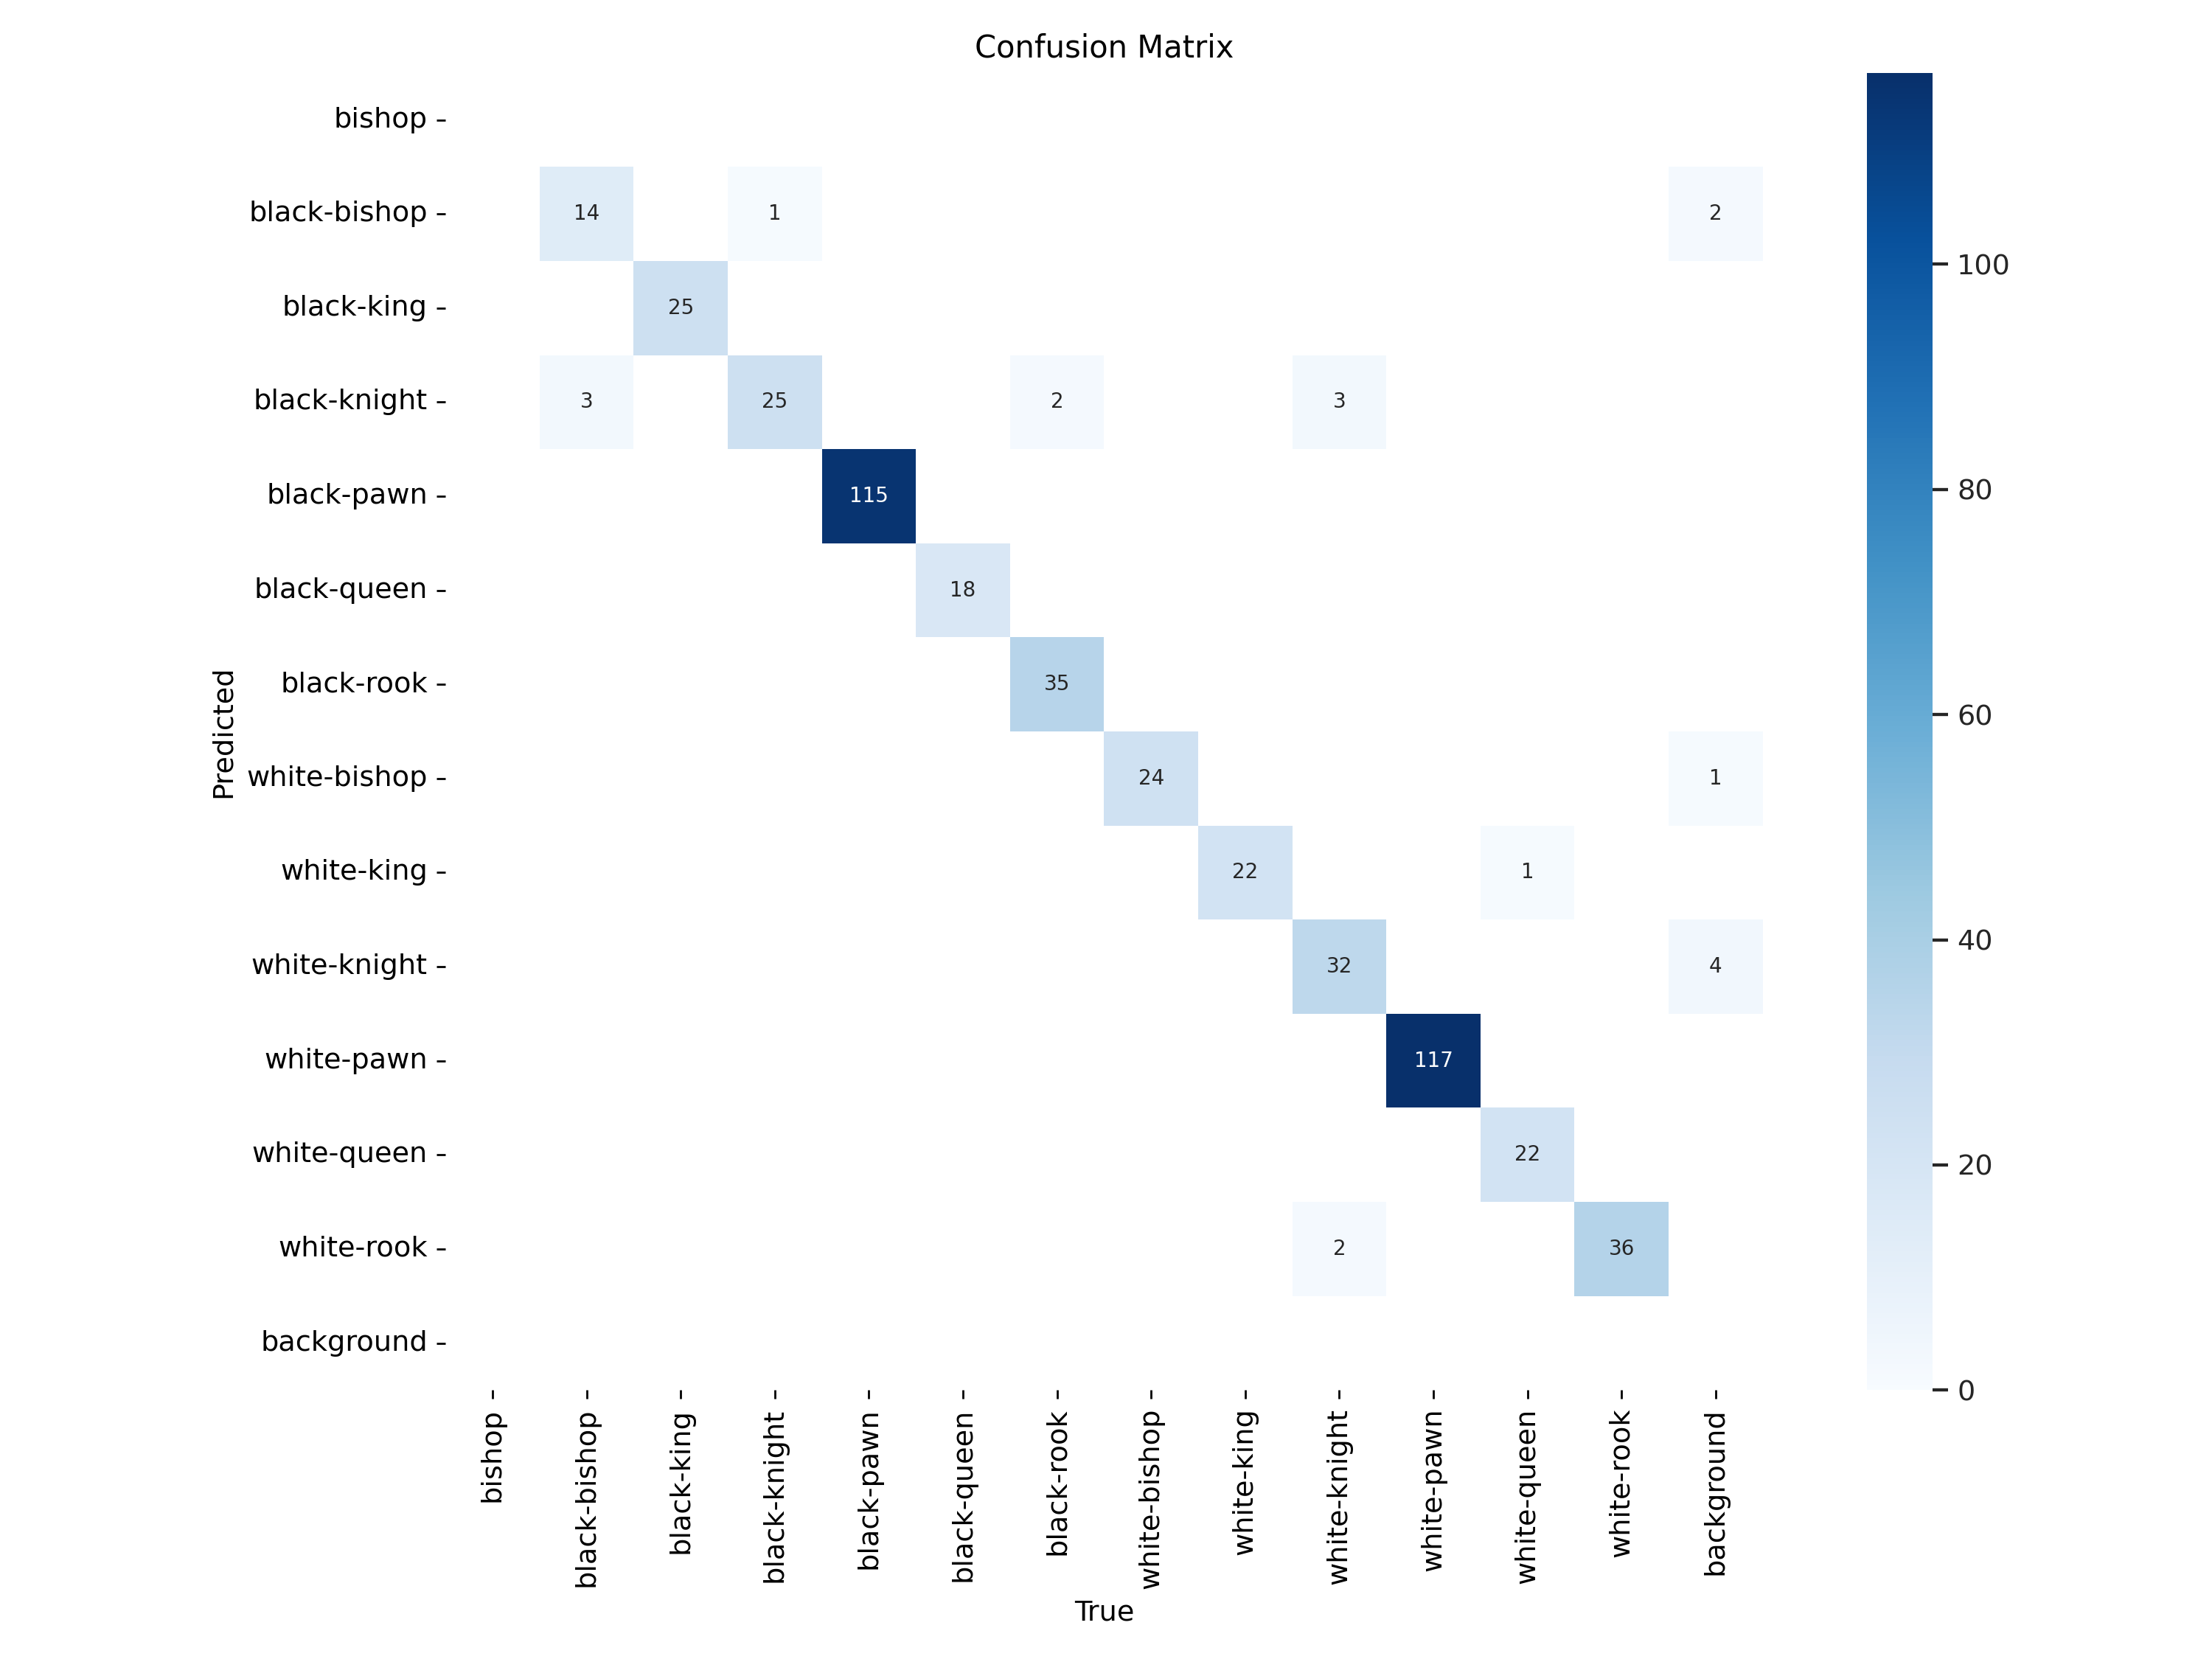

In [12]:
from IPython.display import display, Image
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

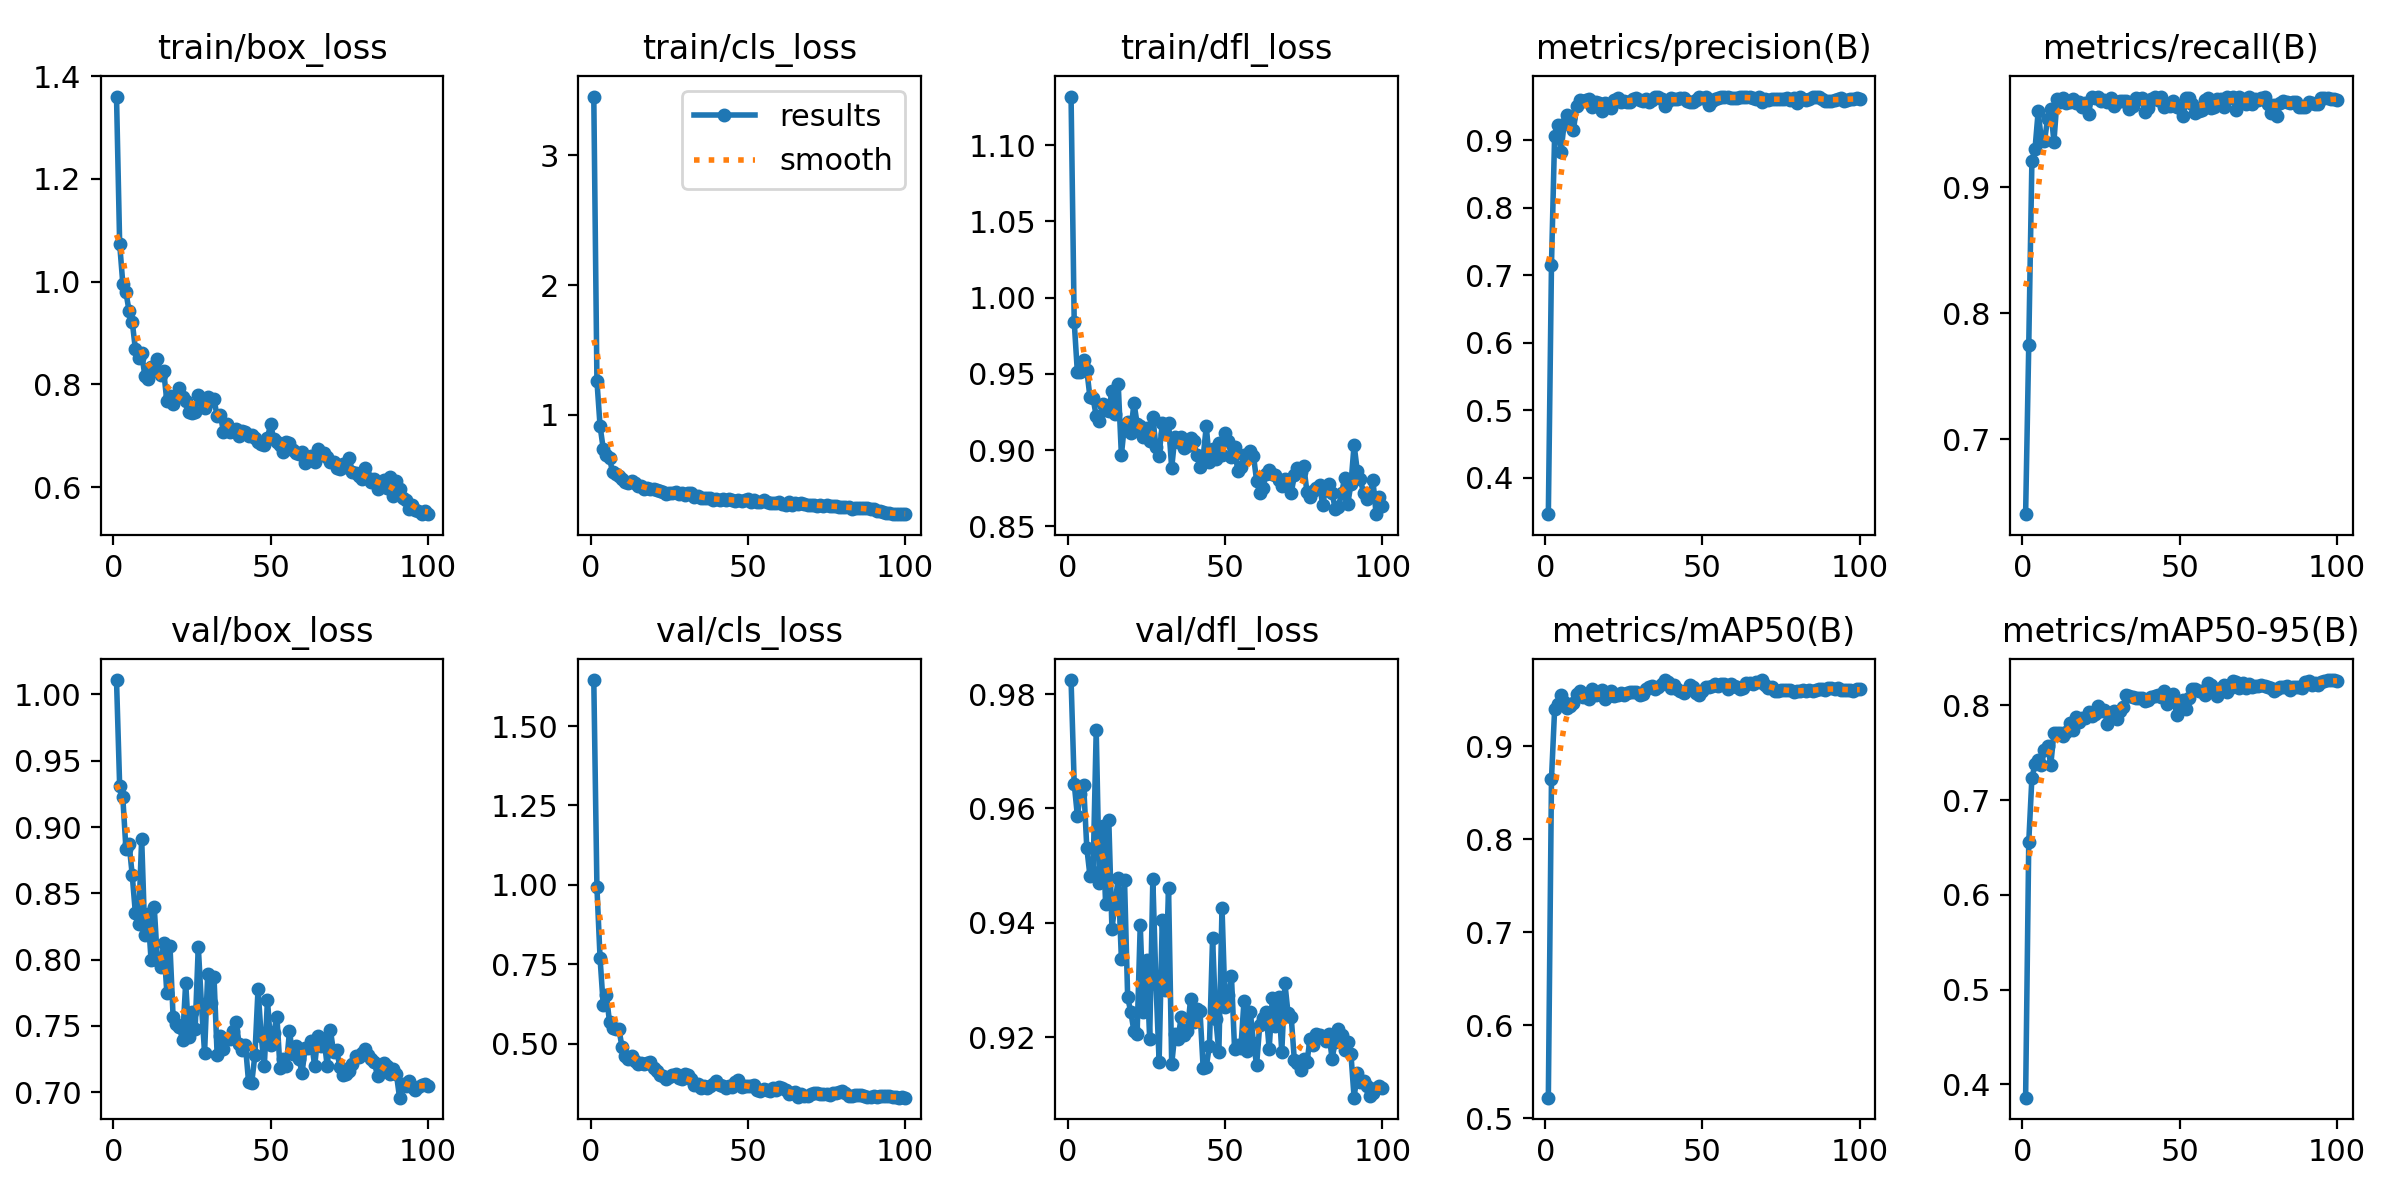

In [13]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

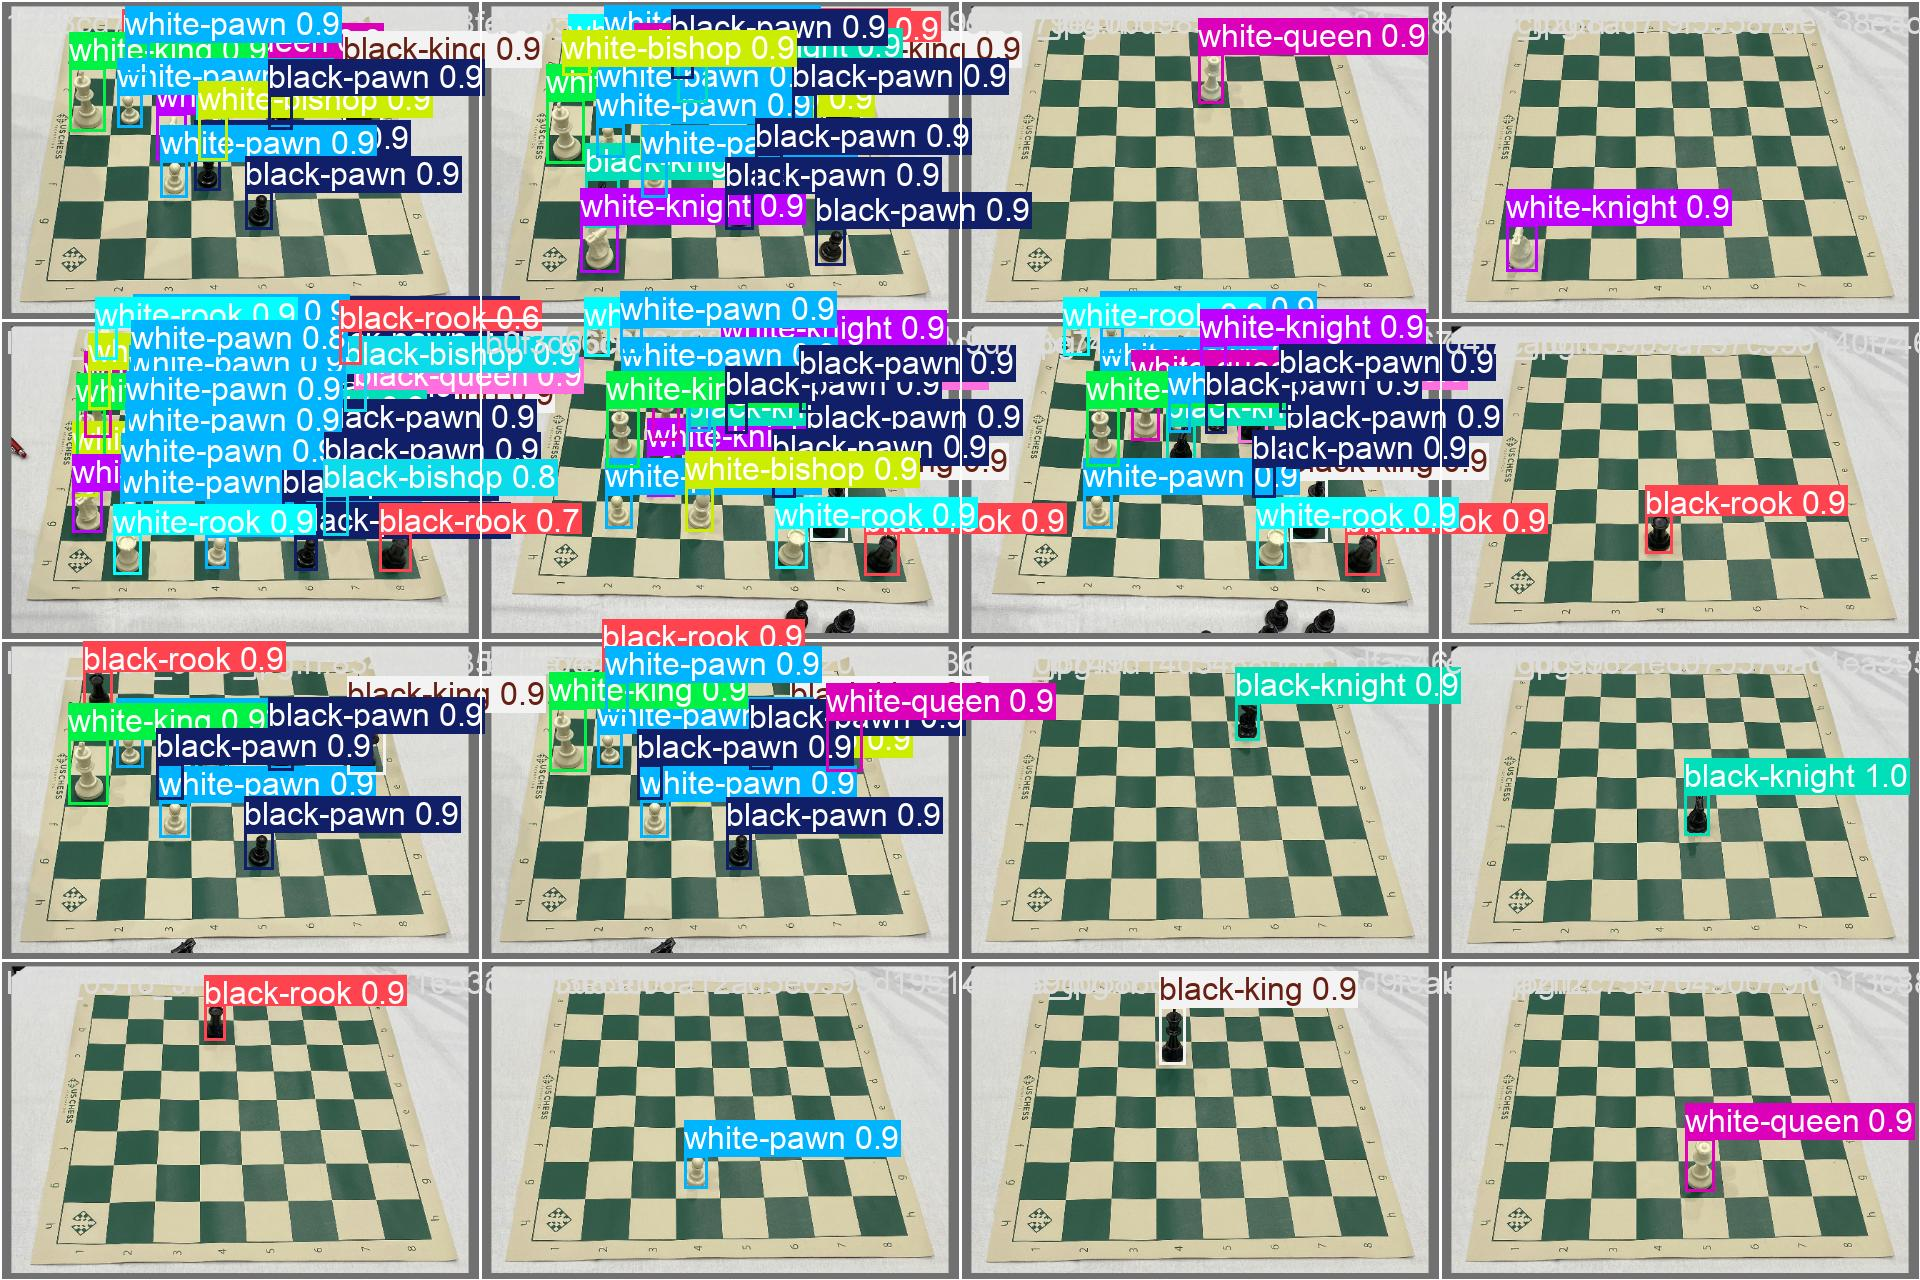

In [14]:
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

# Validate the Model

You can use the YOLO CLI to validate the model on a validation set. This will give you the mAP score for the model.

In [15]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data=$dataset_yaml

Ultralytics YOLOv8.2.99 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15970MiB)
Model summary (fused): 218 layers, 25,847,287 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /home/pyrat/projects/notebooks/notebooks/dataset/valid/labels.cach
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         43        497      0.962       0.97      0.961      0.828
          black-bishop         10         17      0.917      0.882      0.906      0.756
            black-king         25         25      0.989          1      0.995      0.891
          black-knight         19         26      0.776      0.962      0.819      0.692
            black-pawn         23        115      0.998          1      0.995       0.82
           black-queen         18         18      0.986          1      0.995      0.842
            black-rook         25         37          1       0.92      0.961      0.825
          white-bishop     

## Inference on the Test Set

You can use the YOLO CLI to run inference on the test set. This will give you the predictions for the test set and we can visualize them here.

In [16]:
dataset_location = f"{HOME}/dataset"
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=$dataset_location/test/images save=True

Ultralytics YOLOv8.2.99 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15970MiB)
Model summary (fused): 218 layers, 25,847,287 parameters, 0 gradients, 78.7 GFLOPs

image 1/44 /home/pyrat/projects/notebooks/notebooks/dataset/test/images/0b2252c93c53e1b2e61d485b22328e2e_jpg.rf.a997daf5b7b349b9adbce8c901e5a247.ad02582b3925.jpg: 448x640 1 white-rook, 13.7ms
image 2/44 /home/pyrat/projects/notebooks/notebooks/dataset/test/images/15cc23c777b00d0e123f9df468f2852b_jpg.rf.79003baf1da51a2980439a48fbceac0f.e5c46213ae13.jpg: 448x640 2 black-bishops, 1 black-king, 2 black-pawns, 1 white-bishop, 1 white-king, 1 white-pawn, 11.4ms
image 3/44 /home/pyrat/projects/notebooks/notebooks/dataset/test/images/1be2a621f309c7482e9a79ad5b23ecbe_jpg.rf.ea675f2be9a8205b931cf5ce53bb9fe2.8edaf631feb5.jpg: 448x640 1 bishop, 2 black-bishops, 1 black-king, 2 black-pawns, 1 white-bishop, 1 white-king, 1 white-pawn, 11.3ms
image 4/44 /home/pyrat/projects/notebooks/notebooks/dataset/test/images/2

## Visualize the Predictions

Lets look at some of the predictions made by the model on the test set.

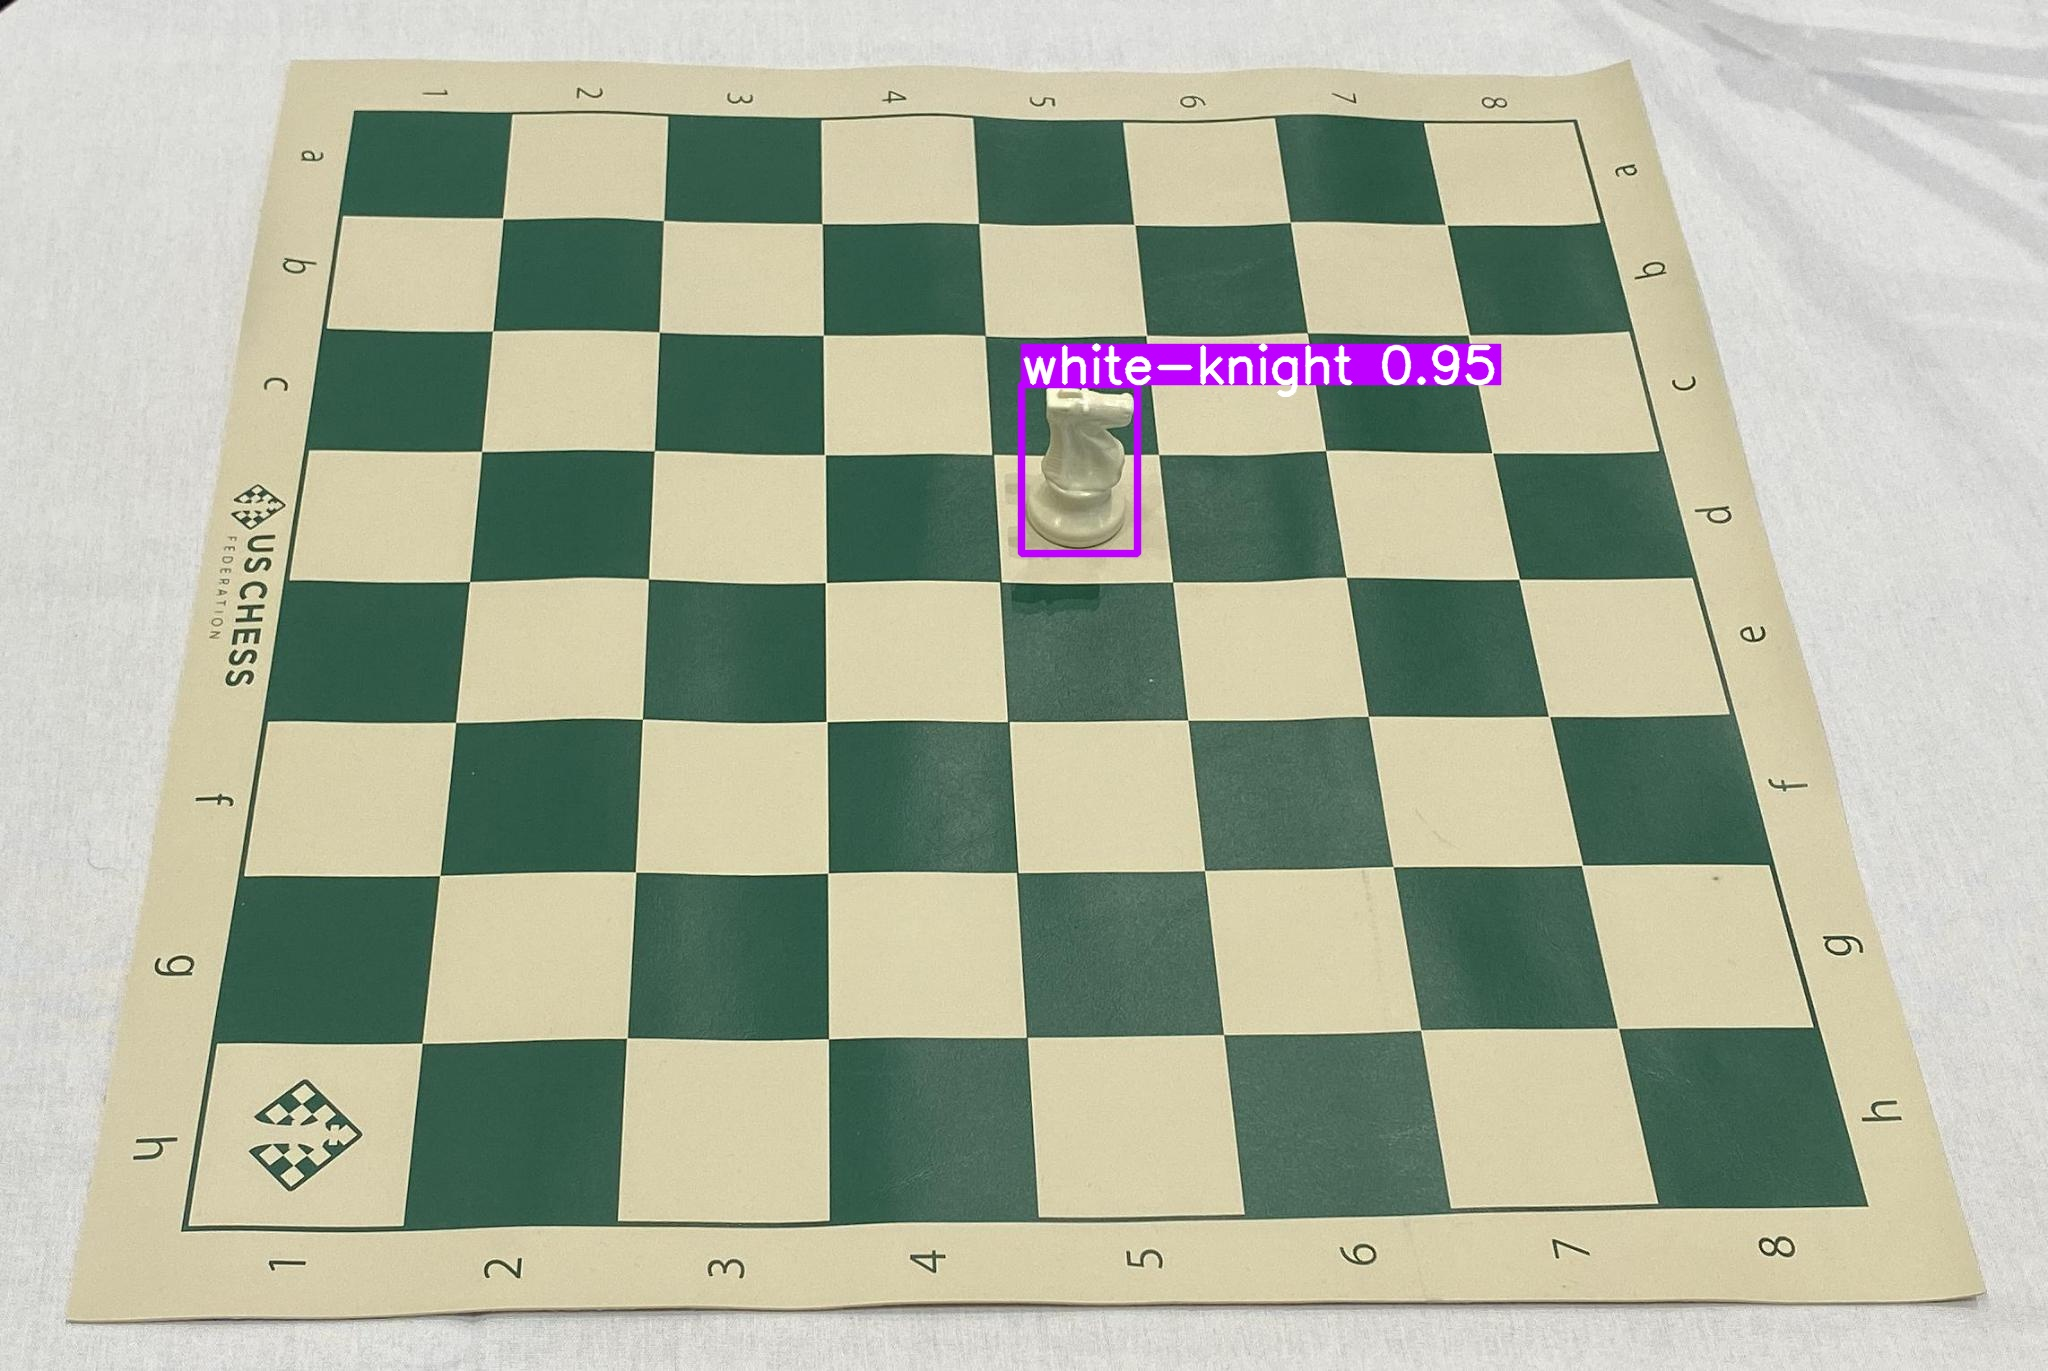

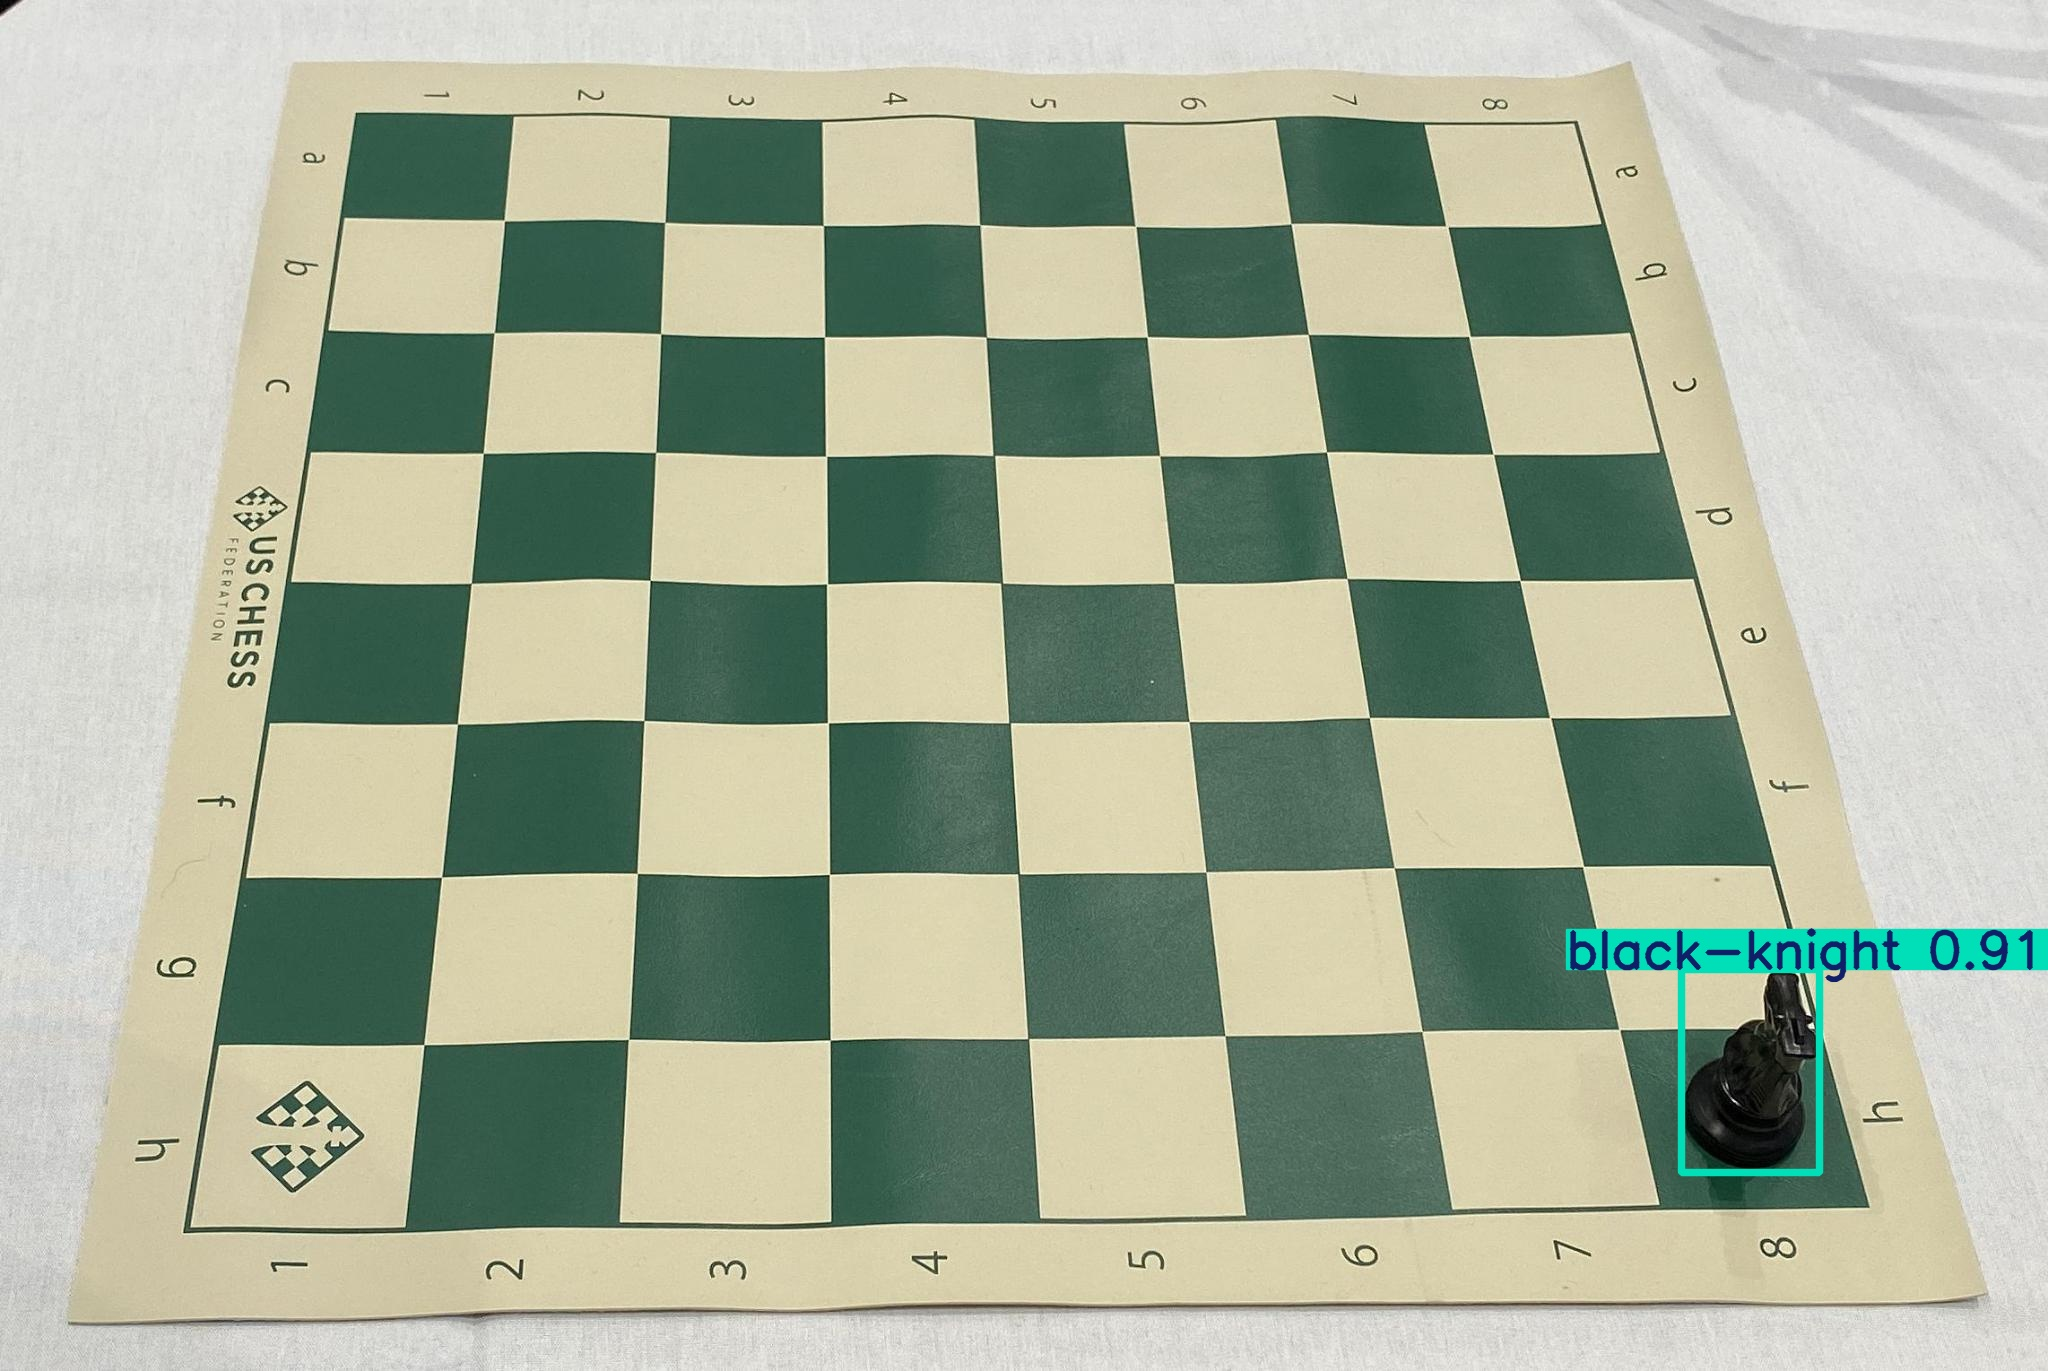

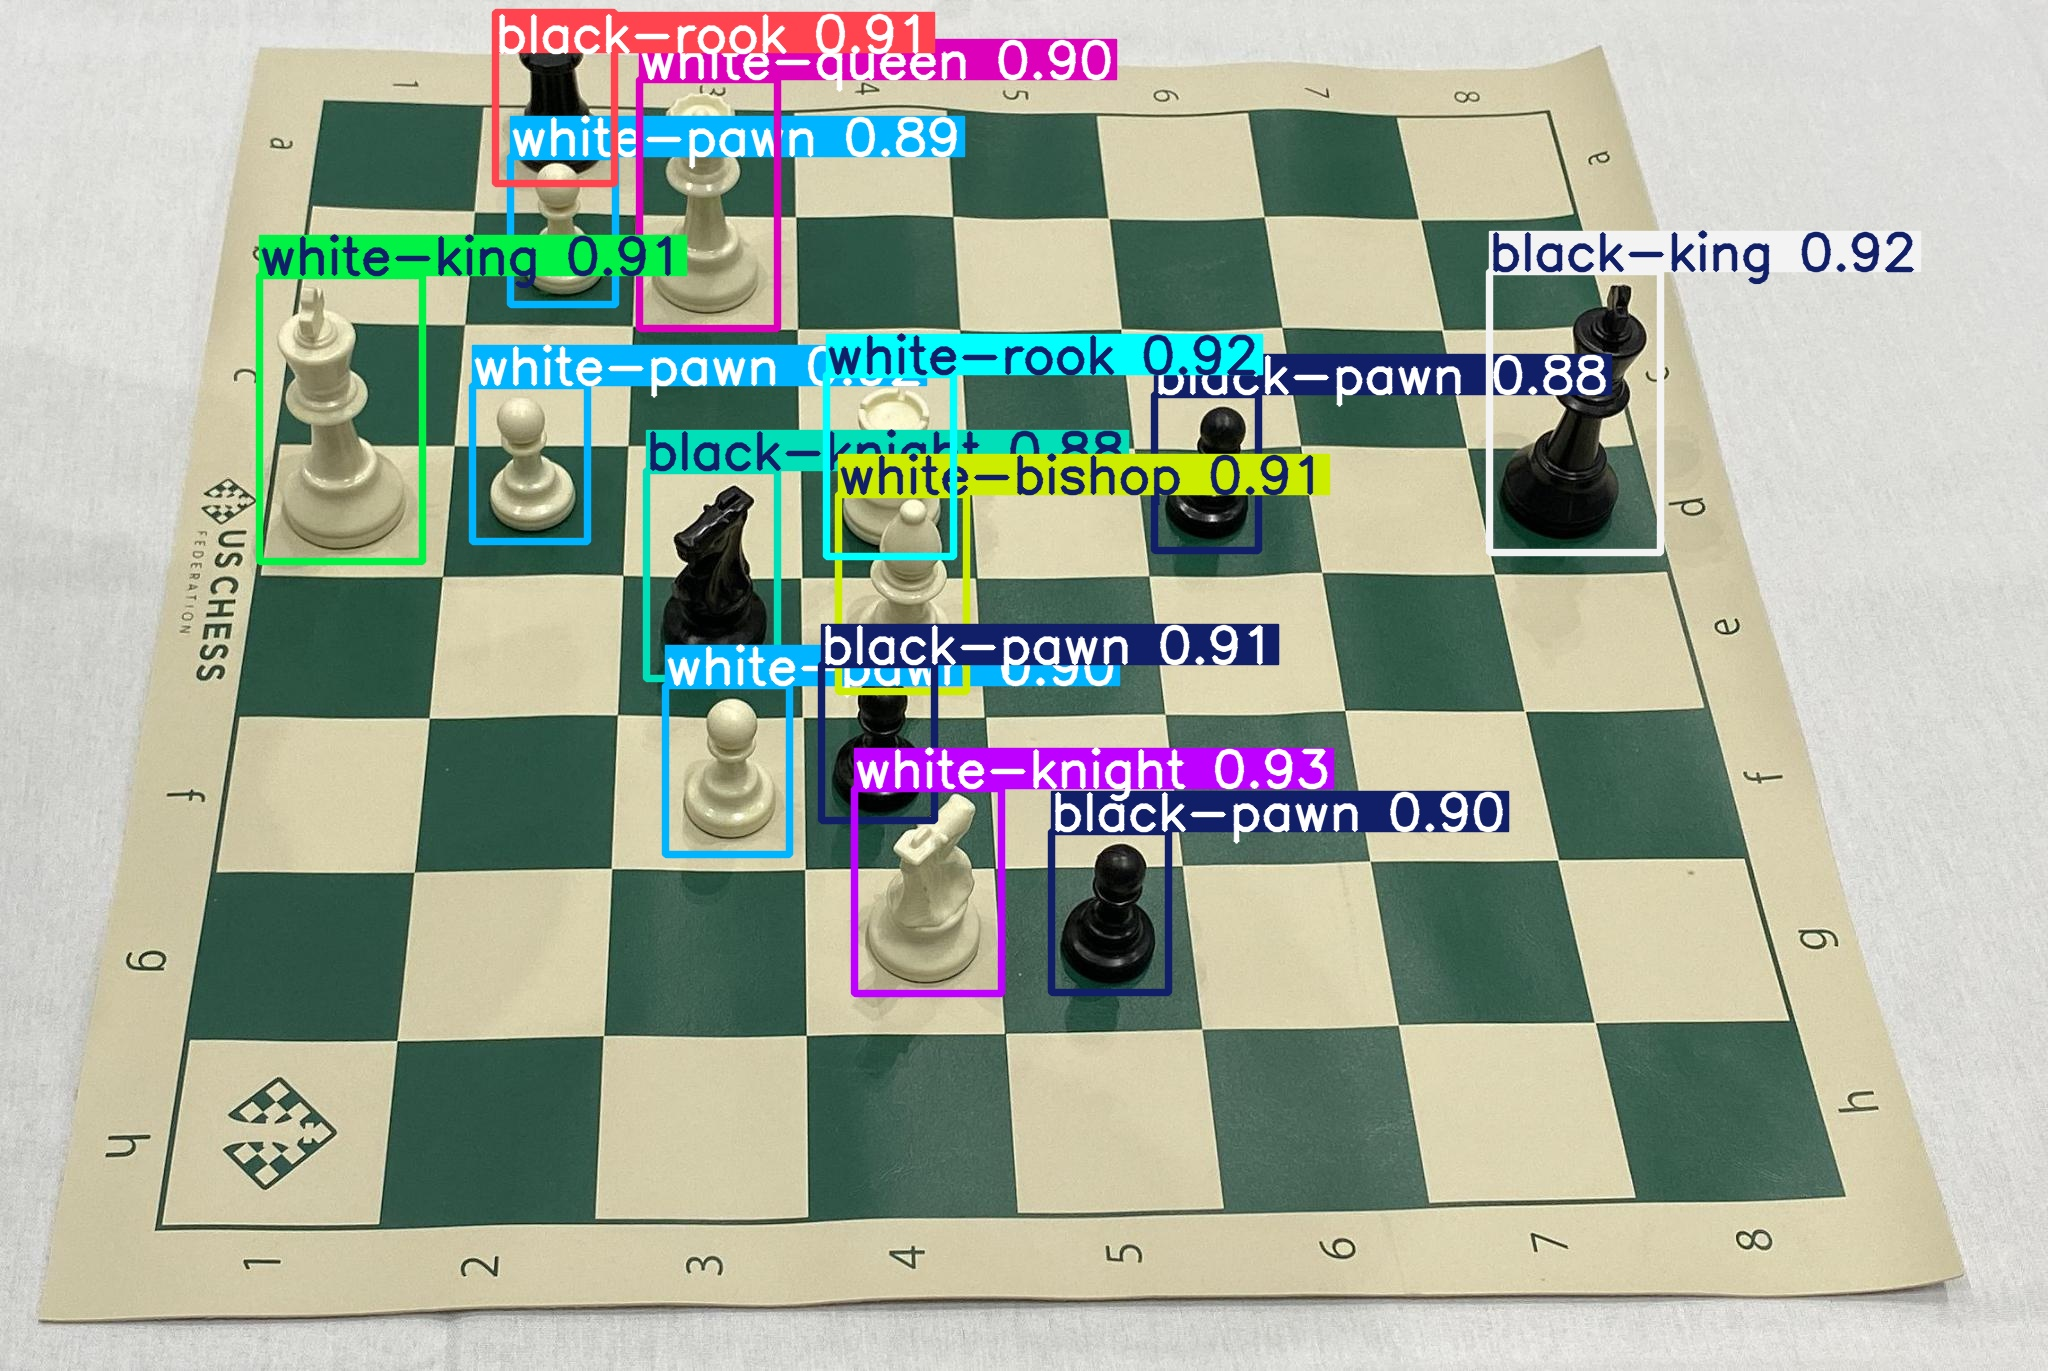

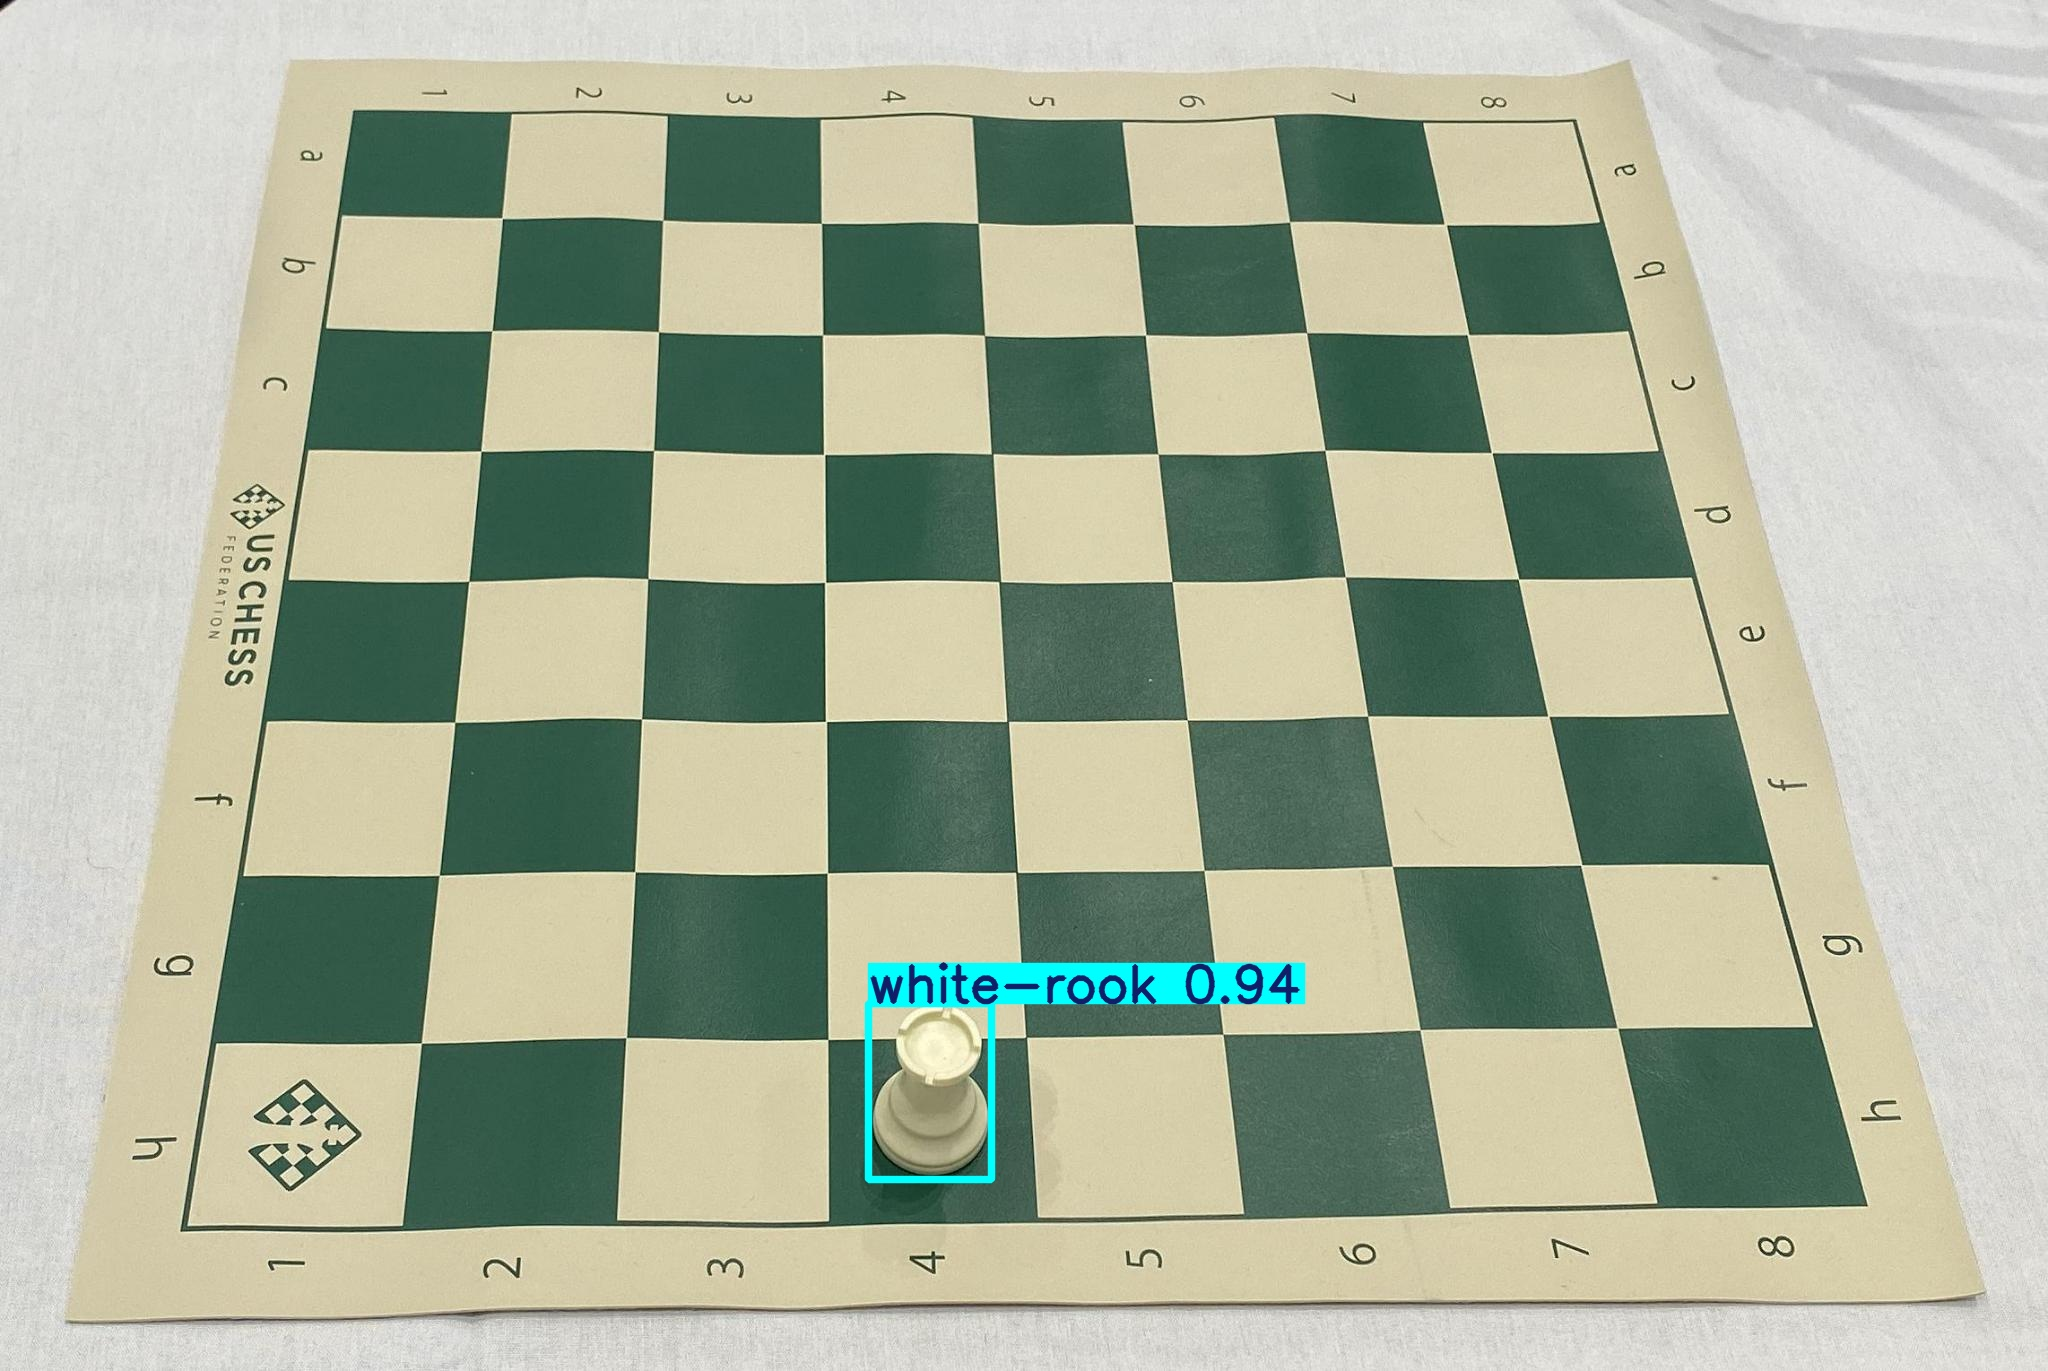

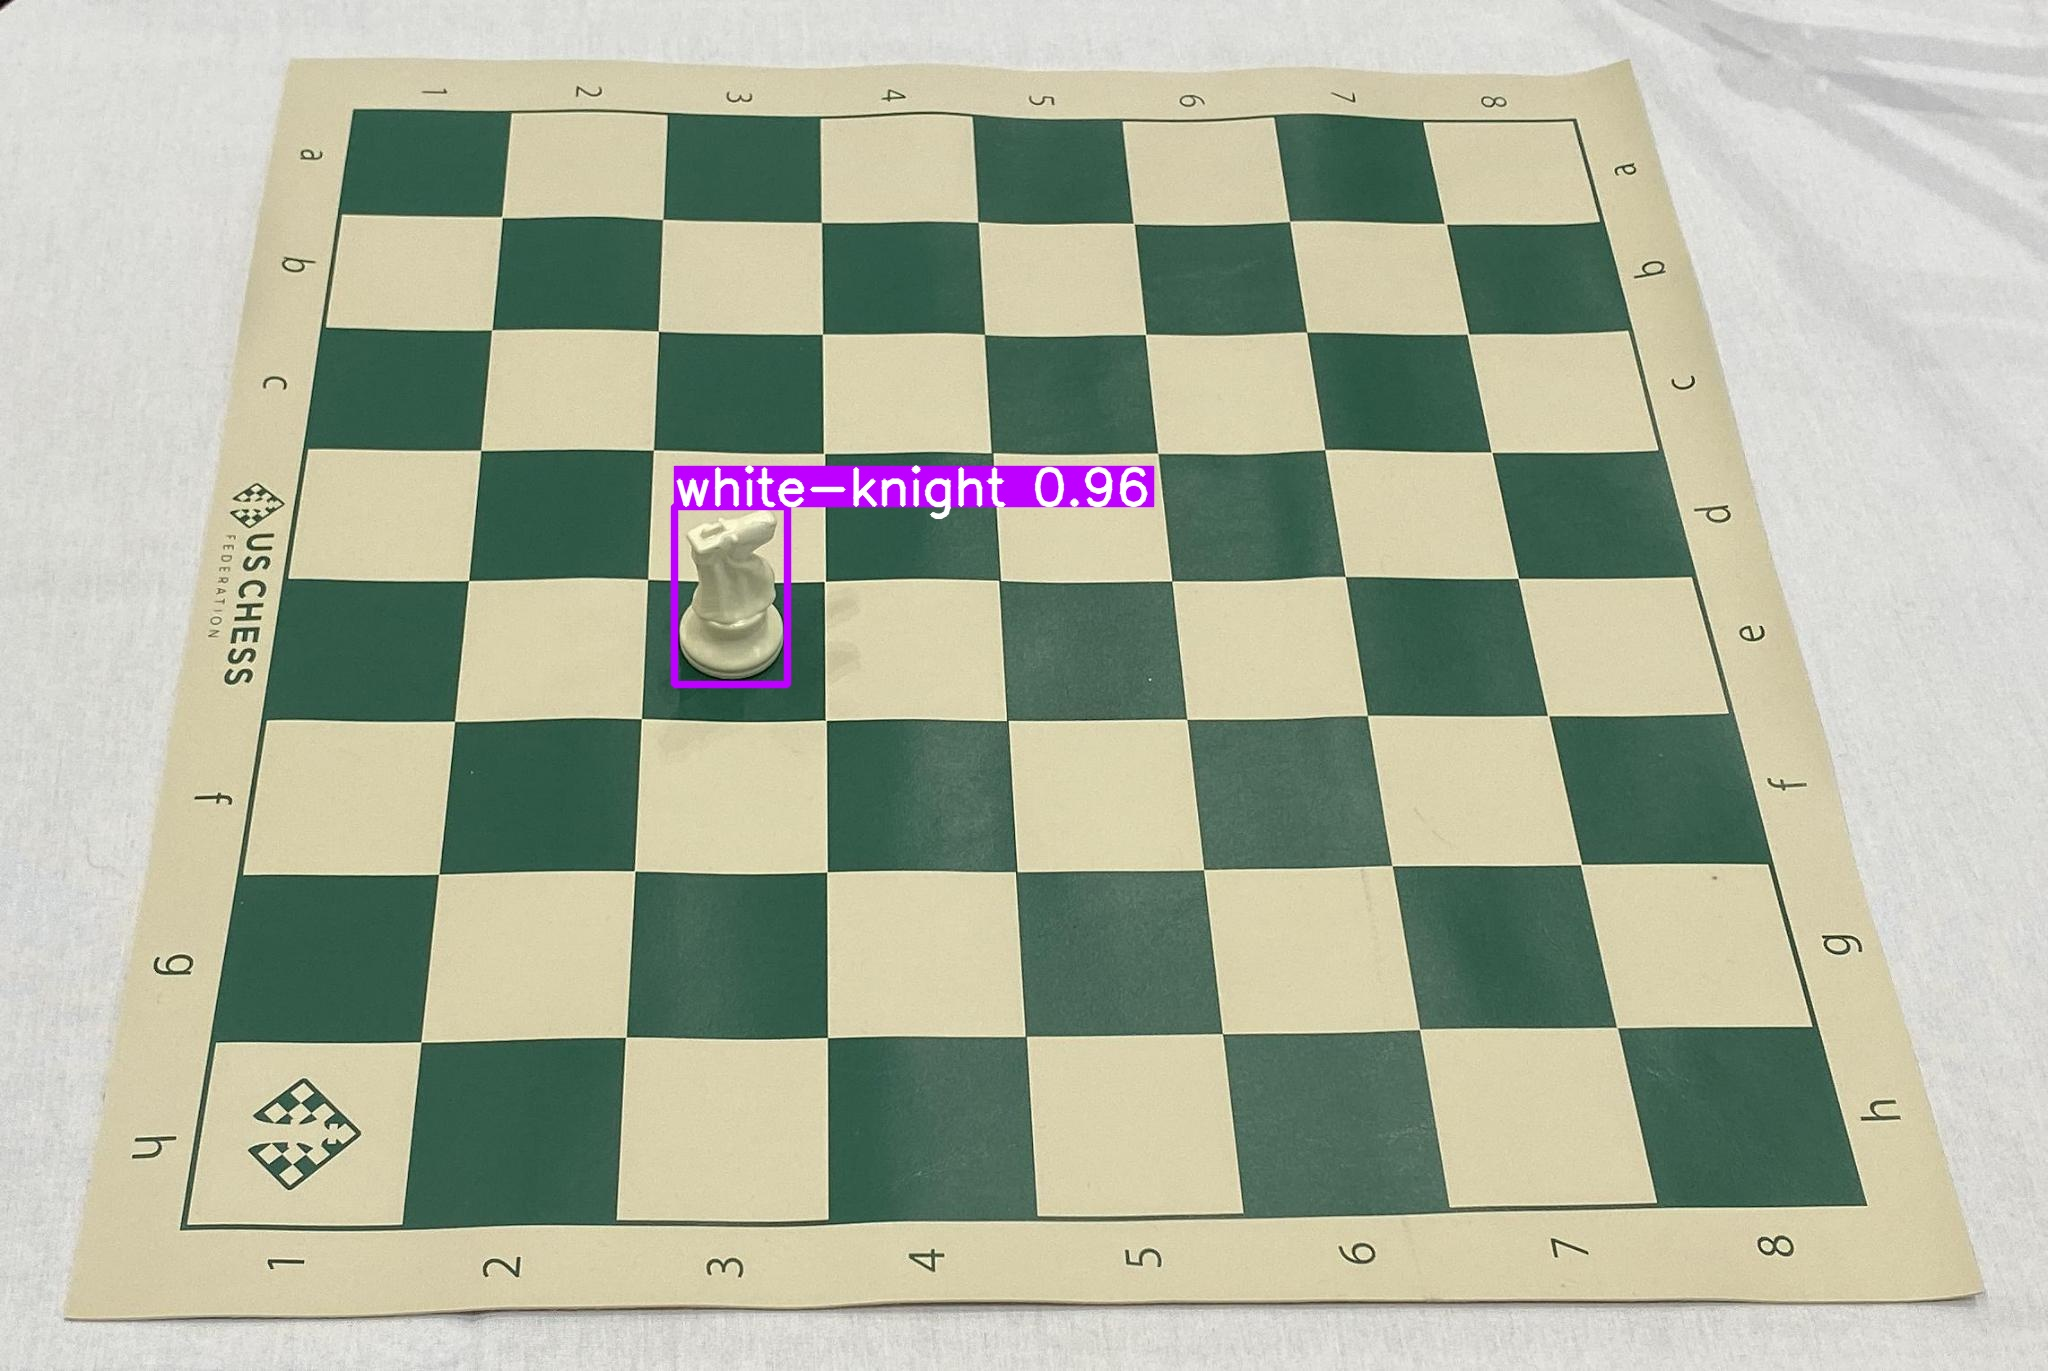

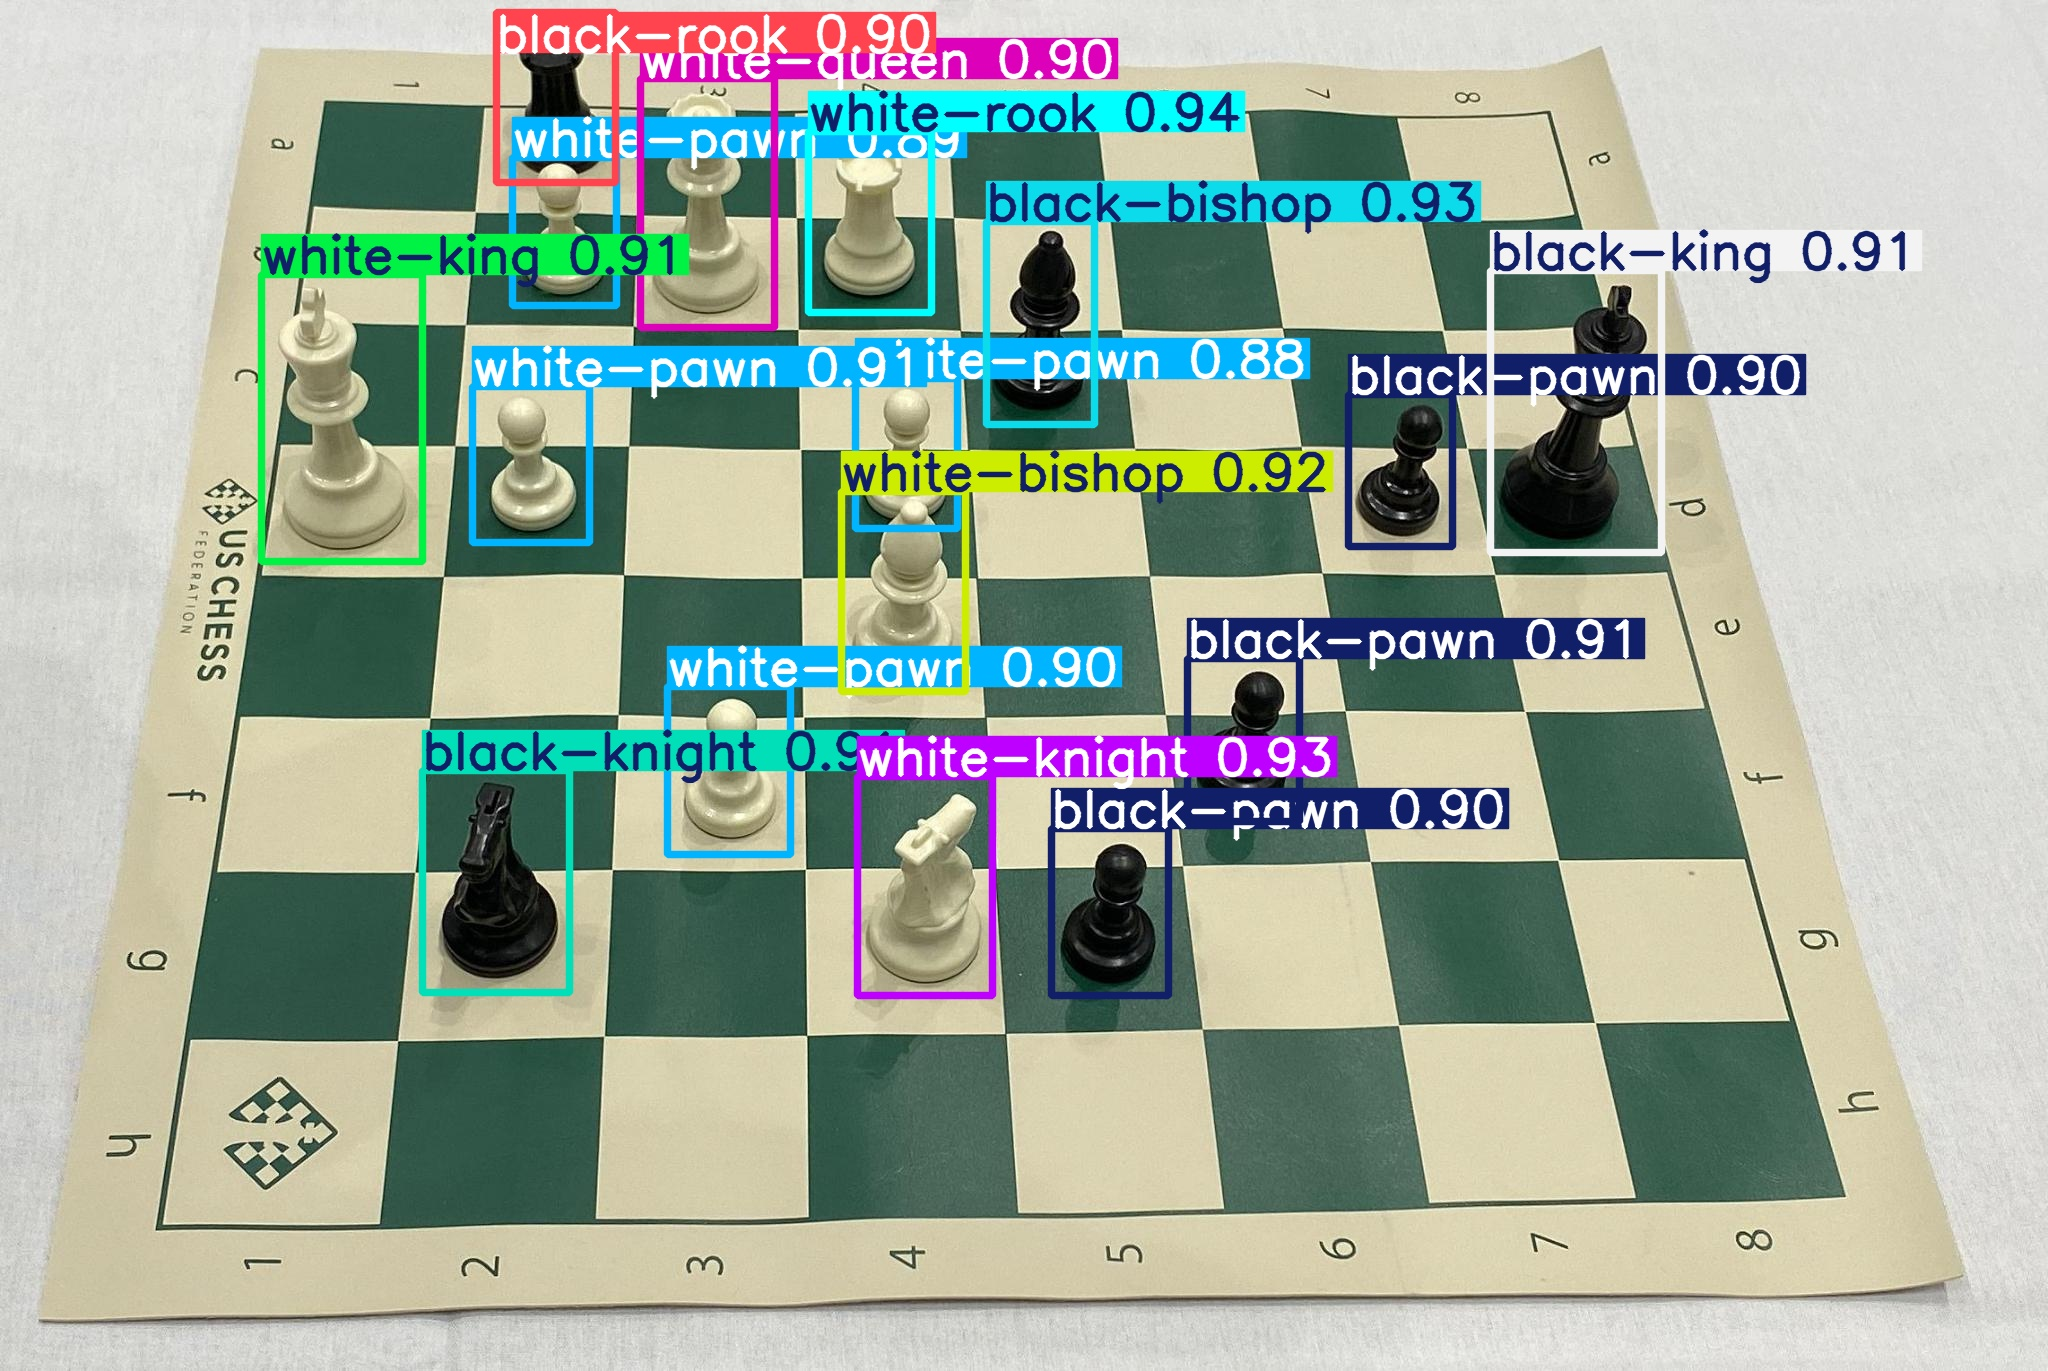

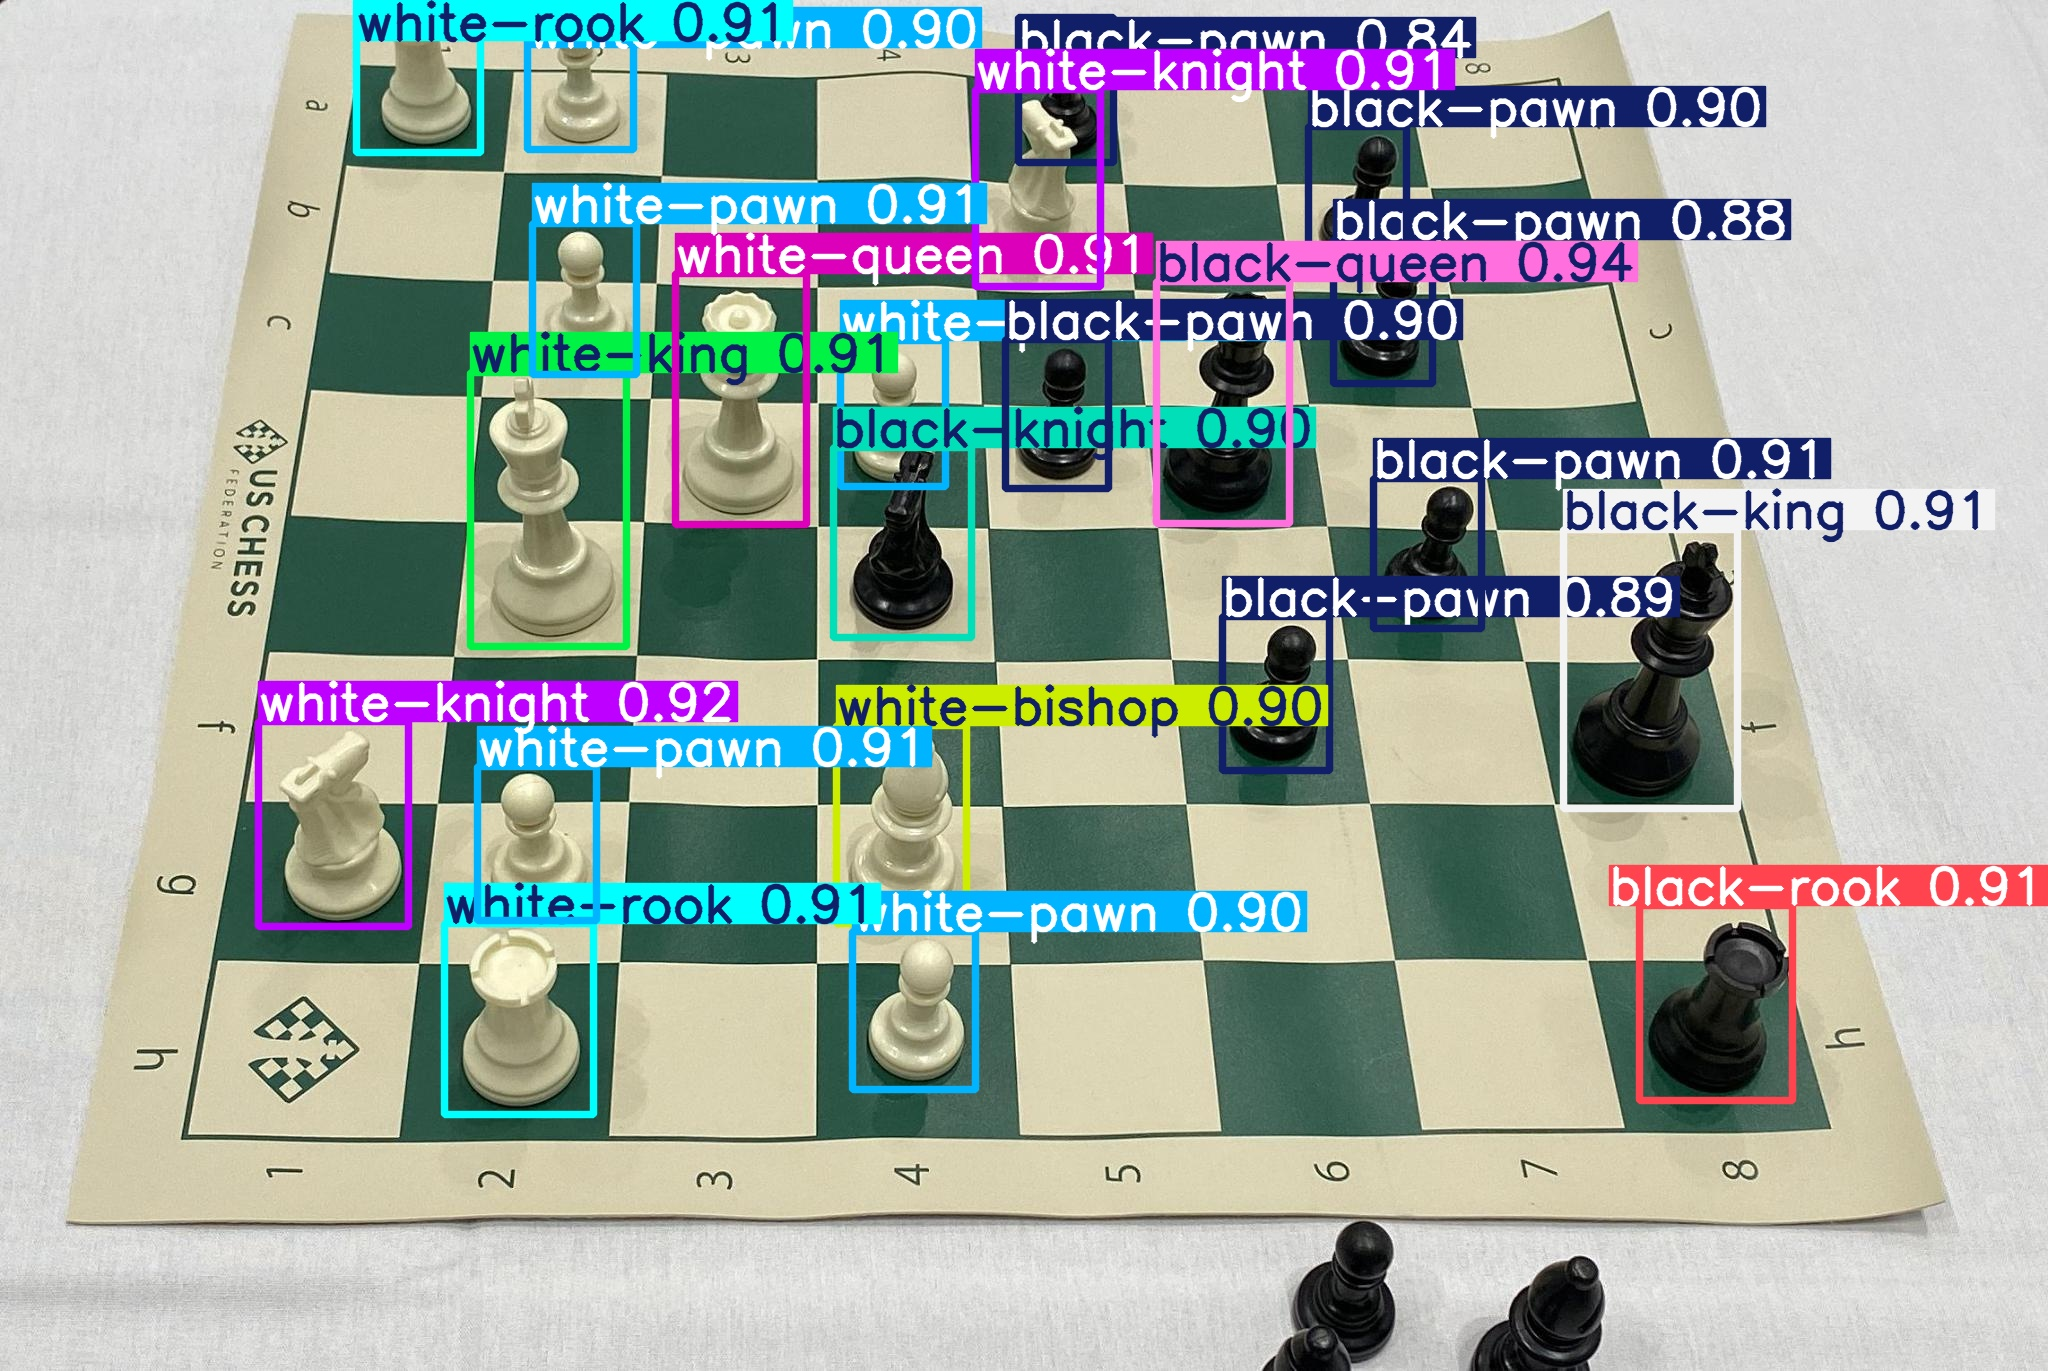

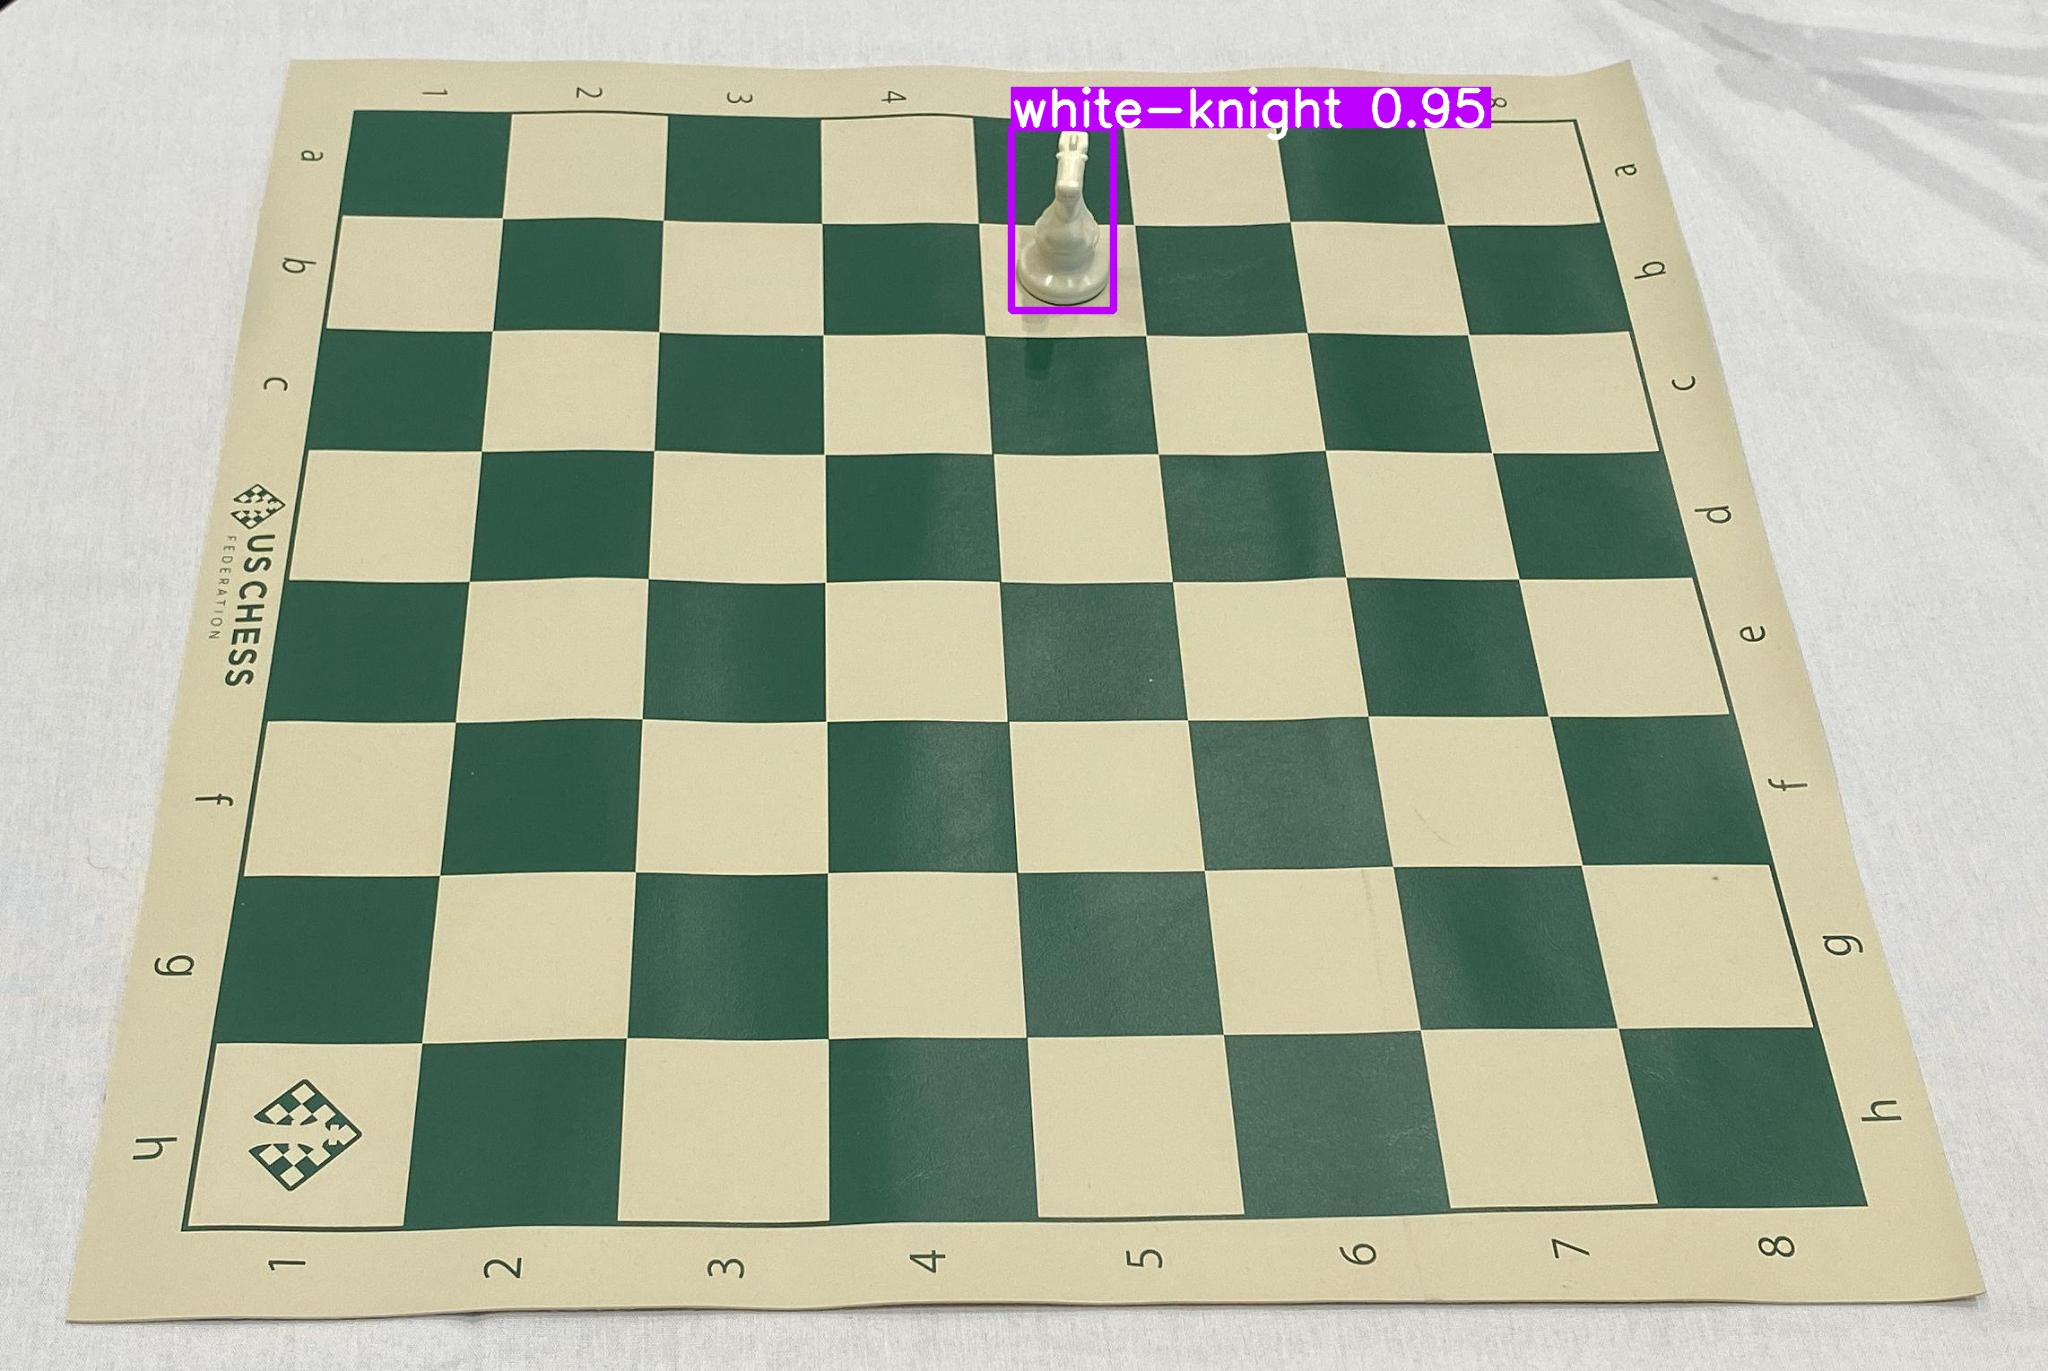

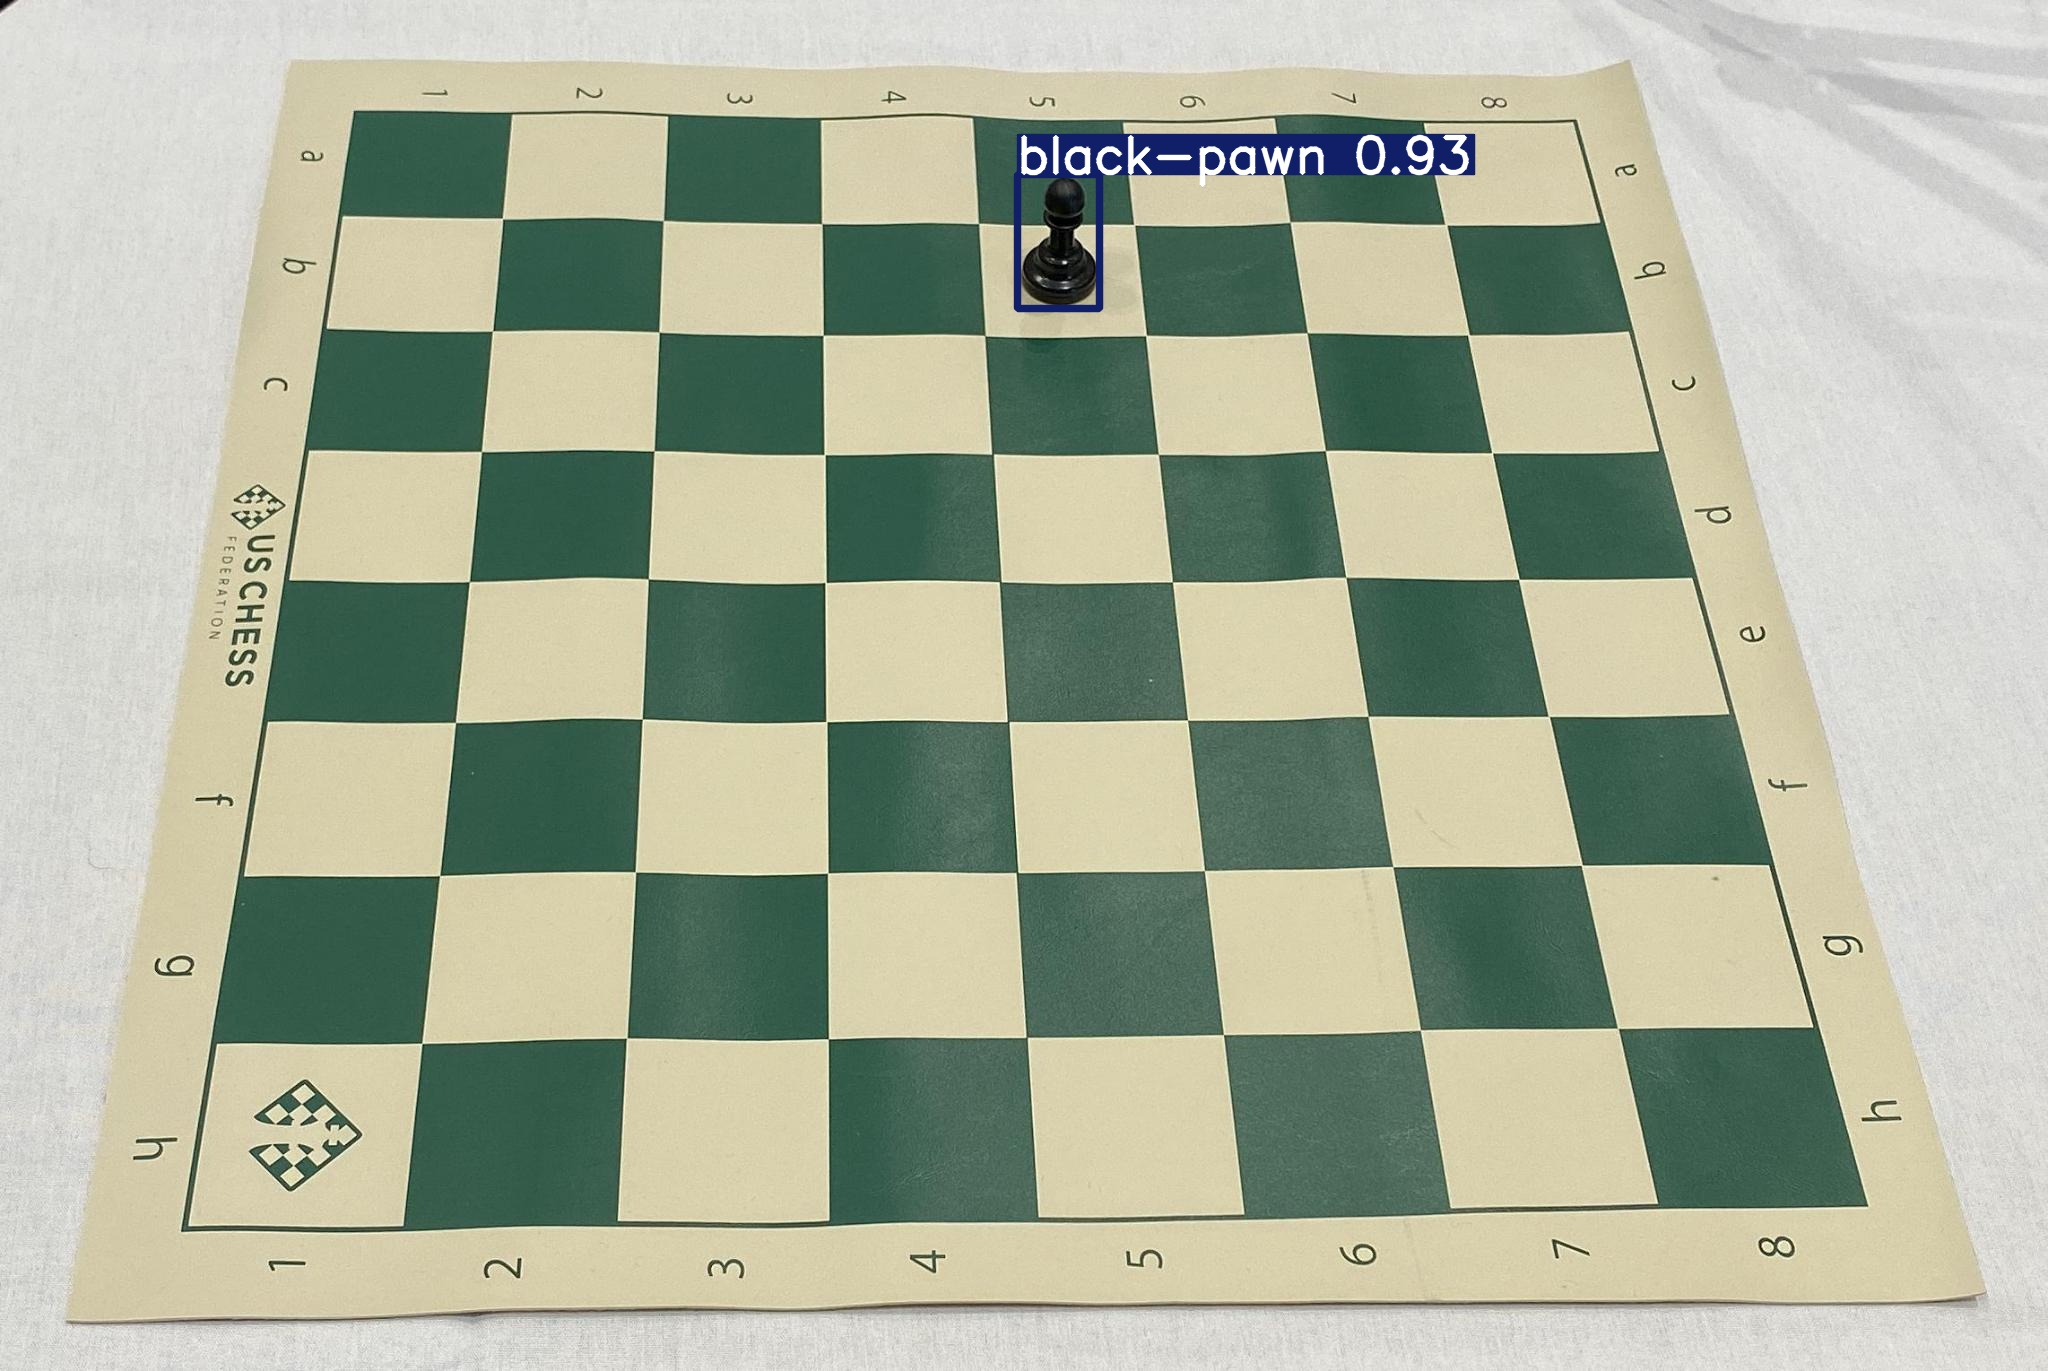

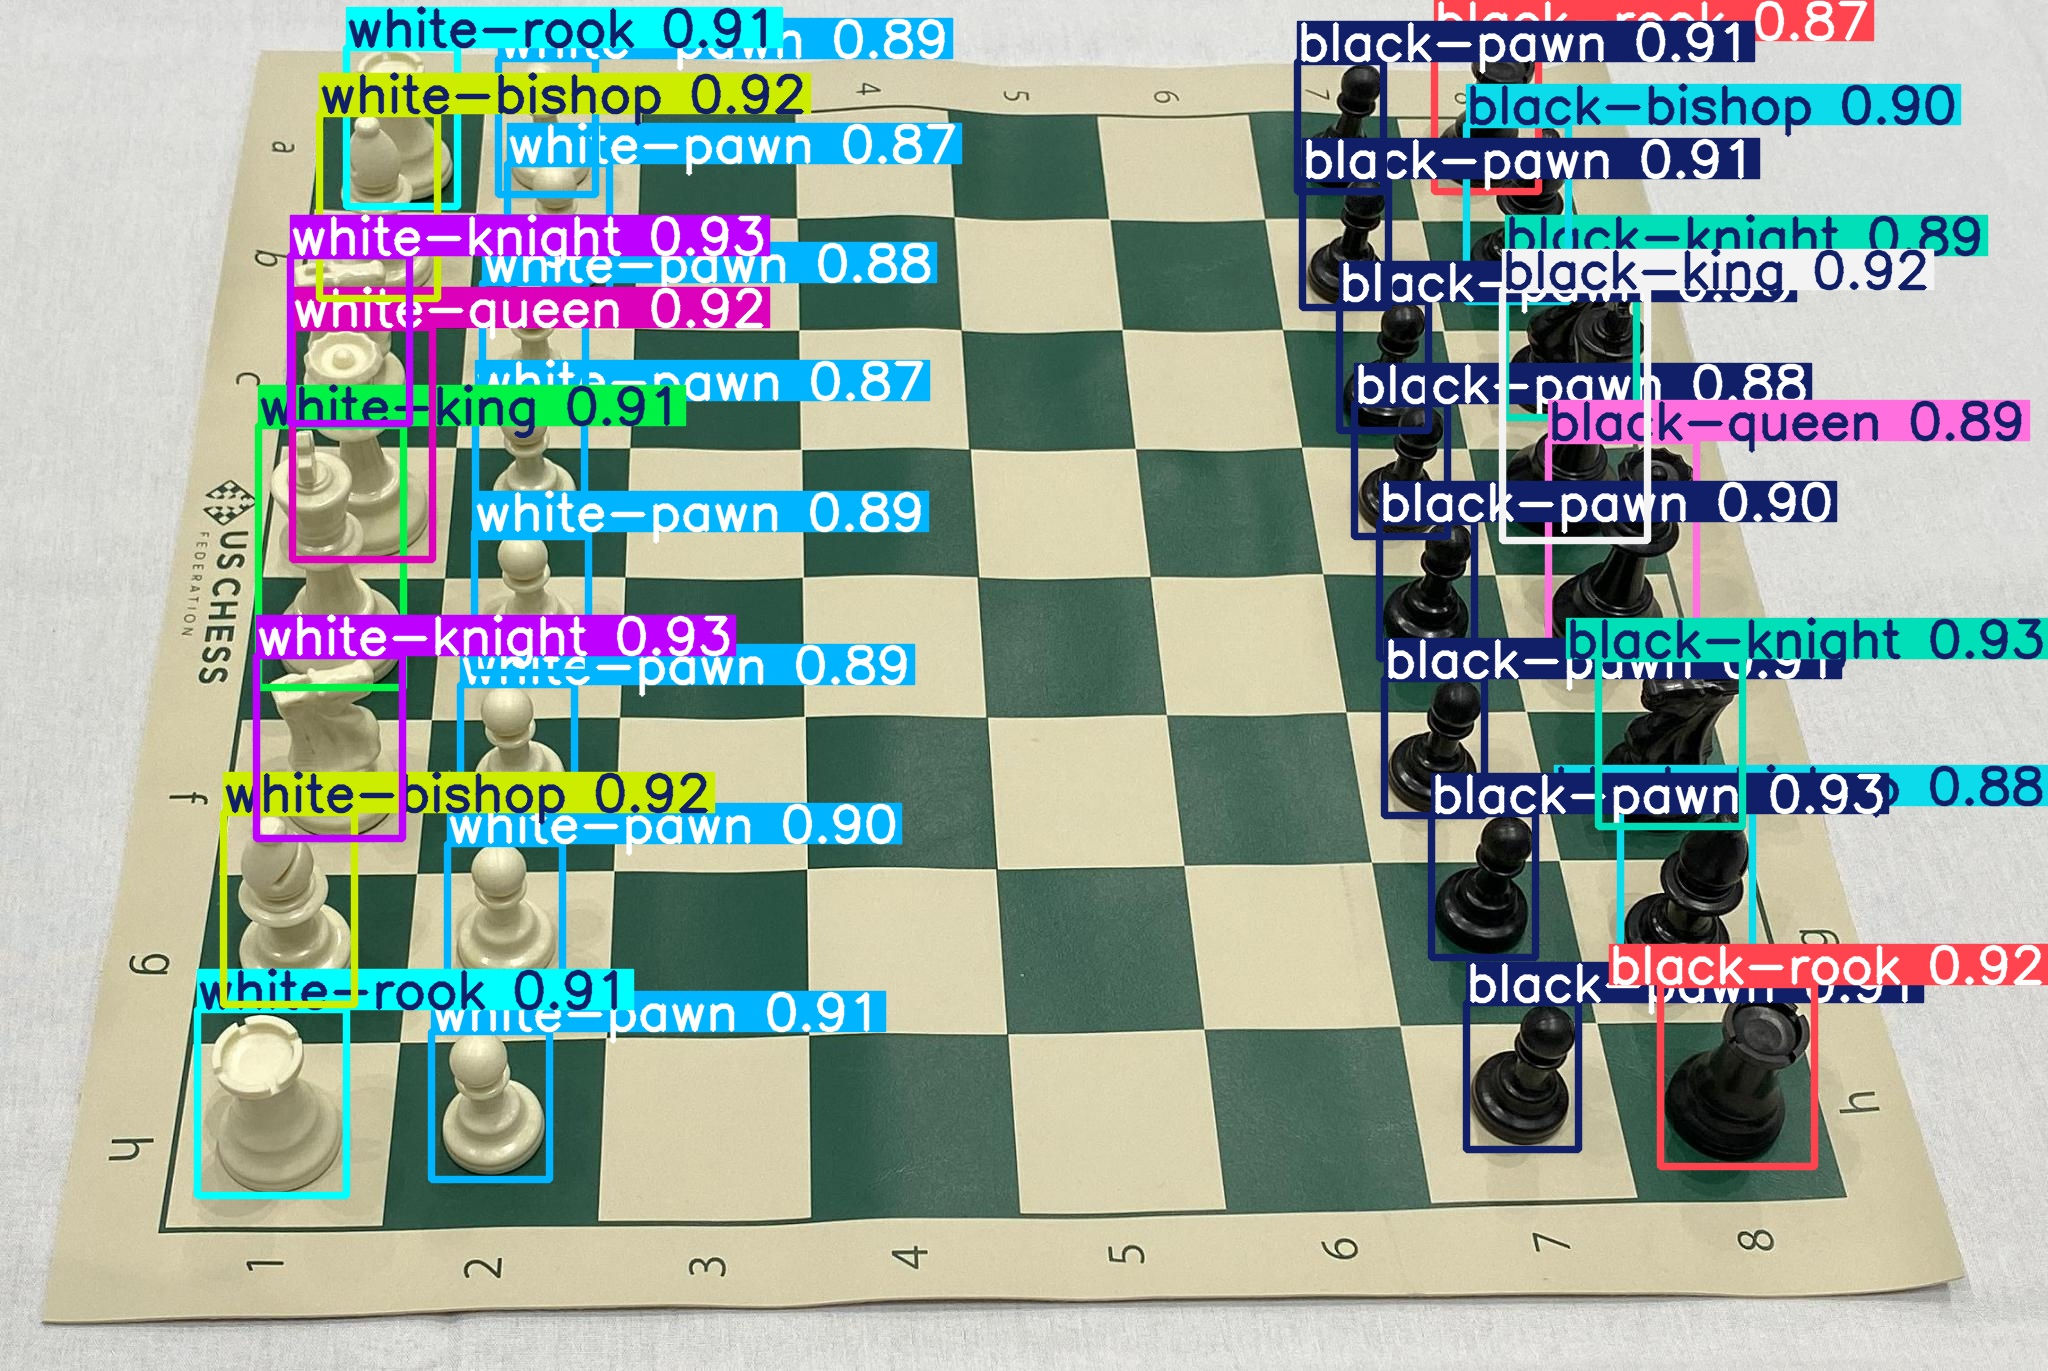

In [22]:

import glob
import random

from IPython.display import Image, display

# Get all image paths
image_paths = glob.glob(f'{HOME}/runs/detect/predict/*.jpg')

# Select up to 20 random images
random_images = random.sample(image_paths, min(len(image_paths), 10))

# Display the selected images
for image_path in random_images:
    display(Image(filename=image_path, width=600))

## Conclusion

This notebook is a simple example of how to train a YOLOv8 model using the Ultralytics library. You can use this as a starting point for your own projects.

The model is trained on the exported dataset from Oslo and the results are visualized. 

You can find the model weights and the training results in the `runs` folder. Generally `best.pt` is the best model and `results.png` is the confusion matrix.